# Exploring Catchment Regionalization throught HydroLSTM

## Libraries



In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib.ticker import FormatStrFormatter


import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical computations
from tqdm import tqdm  # Importing tqdm for progress bars
import math
import os  # Import the os module for accessing file paths and directories
import sys
from pathlib import Path
from scipy import stats
import pickle
from scipy.special import expit
from scipy.optimize import curve_fit
from scipy.special import gamma
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas
import rasterio
from rasterio.plot import show
from IPython.display import Image, display
import xarray as xr

from numpy import dot
from numpy.linalg import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_graphviz
#import graphviz
import re
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


# Get the current working directory
current_dir = os.getcwd()

# Determine the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the directory containing your scripts to the system path
script_dir = parent_dir + '/Code'
sys.path.append(script_dir)

from Hydro_LSTM import *
from HydroLSTM_global3 import *
from utils import *

# Fig 1 HydroLSTM and RF coupling

In [2]:
# Specify the path to the BMP file
image_path = 'Fig 1 Training Regional HydroLSTM.jpg'

# Create an Image object
img = Image(filename=image_path)

# Display the image
display(img)

### Reading Performance of Local HydroLSTM

In [3]:

# Constructing the path to the CSV file containing the list and results
list_path = current_dir + '/' + 'list.csv'
path = parent_dir + '/Results'

# Reading the CSV file into a pandas DataFrame
df_list = pd.read_csv(list_path, header=None)

# Setting the index of the DataFrame to the values in the first column
df_list.index = df_list[0].values

# Dropping the first column from the DataFrame
df_list.drop(labels=0, axis=1, inplace=True)

# Extracting the unique list of codes from the DataFrame index
list_codes = df_list.index

# Defining the number of models
n_models = 20

# Defining a list of lags
list_lags = [4, 8, 16, 32, 64, 128, 256, 512]

# Adding columns for KGE values and lag in the DataFrame
for lag in list_lags:
    df_list['KGE_' + str(lag)] = np.nan

# Making a copy of the DataFrame
loc_df_list = df_list.copy()

# Printing a message
print('Reading performance for each Lag and estimating the best one:')

# Looping through each code in the list
for code in tqdm(list_codes):
    # Iterating over each lag value
    for lag in list_lags:
        # Constructing the path to the hydro summary CSV file for the current code and lag
        path_summary = path + '/hydroLSTM/' + str(code) + '_C1_L' + str(lag) + '_hydro_summary.csv'
        
        # Reading the CSV file into a DataFrame
        table = pd.read_csv(path_summary)
        
        # Finding the maximum KGE value
        max_kge = table.KGE_valid.max()
        
        # Updating the DataFrame with the maximum KGE value
        df_list.at[code, 'KGE_' + str(lag)] = max_kge
        loc_df_list.at[code, 'KGE_' + str(lag)] = table.KGE_valid.idxmax()
    
    # Finding the best KGE value and its corresponding lag
    best_kge = df_list.loc[code].max()
    column_i = df_list.columns.get_loc(df_list.loc[code].idxmax())
    
    # Updating the DataFrame with the best KGE value
    df_list.at[code, 'KGE_best'] = best_kge
    df_list.at[code, 'lag'] = int(list_lags[int(column_i)])
    loc_df_list.at[code, 'lag'] = loc_df_list.loc[code, 'KGE_' + str(int(list_lags[int(column_i)]))]

# Creating another copy of the DataFrame
df_list_C1_no_reg = df_list.copy()

# Displaying the summary statistics of the DataFrame
df_list_C1_no_reg.describe()



Reading performance for each Lag and estimating the best one:


100%|█████████████████████████████████████████| 569/569 [00:45<00:00, 12.50it/s]


KGE_4       KGE_8      KGE_16      KGE_32      KGE_64     KGE_128  \
count  569.000000  569.000000  569.000000  569.000000  569.000000  569.000000   
mean     0.457109    0.495829    0.525122    0.568188    0.590380    0.624267   
std      0.777267    0.776023    0.742011    0.573055    0.602904    0.576199   
min    -12.379670  -12.398356  -11.398558   -8.440561   -8.839023   -8.863056   
25%      0.438471    0.507361    0.527999    0.550986    0.576912    0.604011   
50%      0.595620    0.627966    0.651739    0.687338    0.699919    0.725320   
75%      0.699550    0.723324    0.748720    0.777068    0.794764    0.801374   
max      0.915232    0.918421    0.926830    0.935931    0.945334    0.951372   

          KGE_256     KGE_512    KGE_best         lag  
count  569.000000  569.000000  569.000000  569.000000  
mean     0.663514    0.648887    0.712065  211.304042  
std      0.336135    0.267690    0.262809  164.652068  
min     -4.211685   -2.716242   -2.716242    4.000000  
25%      0.608872    0.581735    0.665338   64.000000  
50%      0.727197    0.698725    0.762662  128.000000  
75%      0.807234    0.793680    0.839984  256.000000  
max      0.953698    0.927570    0.953698  512.000000

In [4]:
# Printing a message indicating that the best model is being saved
print('Saving the best model:')

# Looping through each code in the list
for code in tqdm(list_codes):
    # Constructing the path to the saved model file
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    
    # Loading the models from the saved file
    models = pickle.load(open(file_model, "rb"))
    
    # Selecting the best model based on the lag from loc_df_list
    model = models[int(loc_df_list.loc[code, 'lag'])]
    
    # Constructing the path to save the best model
    file_model = path + '/hydroLSTM/best model/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_best_model.pkl'
    
    # Saving the best model to the specified path
    pickle.dump(model, open(file_model, 'wb'))

# Extracting the lag information from df_list_C1_no_reg
df_summary = df_list_C1_no_reg.lag    

# Constructing the path to save the summary of best lags
summ_path = path + '/hydroLSTM/best model/summary_best_lag.csv'

# Saving the lag summary to the specified path as a CSV file
df_summary.to_csv(summ_path)

Saving the best model:


100%|█████████████████████████████████████████| 569/569 [00:09<00:00, 58.62it/s]


### Reading weigths Local HydroLSTM

In [5]:
# Forget gate weights
column_name = []
# Naming columns for precipitation data
for i in range(513):
    column_name_i = 'PP_f_' + str(i)
    column_name.append(column_name_i)
# Naming columns for PET data
for i in range(513, 2 * 513):
    column_name_i = 'PET_f_' + str(i - 513)
    column_name.append(column_name_i)
# Creating a DataFrame to store forget gate weights, indexed by hydrological code
df_weights_f = pd.DataFrame(columns=column_name, index=pd.read_csv(list_path, header=None)[0].values)

# Reading forget gate weights
print('Reading Forget gate:')
for code in tqdm(list_codes):
    # Loading the trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    w = np.zeros((n_models, 2 * (int(df_list_C1_no_reg.lag[code]) + 1)))
    # Extracting forget gate weights from each model
    for i in range(n_models):
        w[i, :] = models[i].hydro_lstm.weight_input[0, :].detach().numpy()
    w_mean = np.mean(w, axis=0)
    # Storing the mean forget gate weights in the DataFrame
    df_weights_f.loc[code][:int(df_list_C1_no_reg.lag[code] + 1)] = w_mean[:int(df_list_C1_no_reg.lag[code] + 1)]
    df_weights_f.loc[code][513:513 + int(df_list_C1_no_reg.lag[code]) + 1] = w_mean[int(df_list_C1_no_reg.lag[code] + 1):]
df_weights_f = df_weights_f.fillna(0)

# Input gate weights
column_name = []
# Naming columns for precipitation data
for i in range(513):
    column_name_i = 'PP_i_' + str(i)
    column_name.append(column_name_i)
# Naming columns for PET data
for i in range(513, 2 * 513):
    column_name_i = 'PET_i_' + str(i - 513)
    column_name.append(column_name_i)
# Creating a DataFrame to store input gate weights, indexed by hydrological code
df_weights_i = pd.DataFrame(columns=column_name, index=pd.read_csv(list_path, header=None)[0].values)

# Reading input gate weights
print('Reading Input gate:')
for code in tqdm(list_codes):
    # Loading the trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    w = np.zeros((n_models, 2 * (int(df_list_C1_no_reg.lag[code]) + 1)))
    # Extracting input gate weights from each model
    for i in range(n_models):
        w[i, :] = models[i].hydro_lstm.weight_input[1, :].detach().numpy()
    w_mean = np.mean(w, axis=0)
    # Storing the mean input gate weights in the DataFrame
    df_weights_i.loc[code][:int(df_list_C1_no_reg.lag[code] + 1)] = w_mean[:int(df_list_C1_no_reg.lag[code] + 1)]
    df_weights_i.loc[code][513:513 + int(df_list_C1_no_reg.lag[code]) + 1] = w_mean[int(df_list_C1_no_reg.lag[code] + 1):]
df_weights_i = df_weights_i.fillna(0)

# Output gate weights
# Initialize column names for precipitation and PET data
column_name = []
for i in range(513):
    column_name_i = 'PP_o_' + str(i)
    column_name.append(column_name_i)
for i in range(513, 2 * 513):
    column_name_i = 'PET_o_' + str(i - 513)
    column_name.append(column_name_i)
# Create a DataFrame to store output gate weights, indexed by hydrological code
df_weights_o = pd.DataFrame(columns=column_name, index=pd.read_csv(list_path, header=None)[0].values)

# Reading output gate weights
print('Reading Output gate:')
for code in tqdm(list_codes):
    # Load trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    w = np.zeros((n_models, 2 * (int(df_list_C1_no_reg.lag[code]) + 1)))
    # Extract output gate weights from each model
    for i in range(n_models):
        w[i, :] = models[i].hydro_lstm.weight_input[2, :].detach().numpy()
    w_mean = np.mean(w, axis=0)
    # Store the mean output gate weights in the DataFrame
    df_weights_o.loc[code][:int(df_list_C1_no_reg.lag[code] + 1)] = w_mean[:int(df_list_C1_no_reg.lag[code] + 1)]
    df_weights_o.loc[code][513:513 + int(df_list_C1_no_reg.lag[code]) + 1] = w_mean[int(df_list_C1_no_reg.lag[code] + 1):]
df_weights_o = df_weights_o.fillna(0)

# g() function weights
# Create column names for precipitation and PET data for g() function weights
column_name = []
for i in range(513):
    column_name_i = 'PP_g_' + str(i)
    column_name.append(column_name_i)
for i in range(513, 2 * 513):
    column_name_i = 'PET_g_' + str(i - 513)
    column_name.append(column_name_i)
# Create a DataFrame to store g() function weights, indexed by hydrological code
df_weights_g = pd.DataFrame(columns=column_name, index=pd.read_csv(list_path, header=None)[0].values)

# Reading g() function weights
print('Reading g() function:')
for code in tqdm(list_codes):
    # Load trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    # Initialize array to store g() function weights for each model
    w = np.zeros((n_models, 2 * (int(df_list_C1_no_reg.lag[code]) + 1)))
    # Extract g() function weights from each model
    for i in range(n_models):
        w[i, :] = models[i].hydro_lstm.weight_input[3, :].detach().numpy()
    w_mean = np.mean(w, axis=0)
    # Store the mean g() function weights in the DataFrame
    df_weights_g.loc[code][:int(df_list_C1_no_reg.lag[code] + 1)] = w_mean[:int(df_list_C1_no_reg.lag[code] + 1)]
    df_weights_g.loc[code][513:513 + int(df_list_C1_no_reg.lag[code]) + 1] = w_mean[int(df_list_C1_no_reg.lag[code] + 1):]
df_weights_g = df_weights_g.fillna(0)

# DataFrame creation for recurrent weights
df_weights_rec = pd.DataFrame(columns=['rec_f', 'rec_i', 'rec_o', 'rec_g'], index=pd.read_csv(list_path, header=None)[0].values)

# Reading recurrent weights
print('Reading recurrent weights:')
for code in tqdm(list_codes):
    # Load trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    # Initialize array to store recurrent weights for each model
    w = np.zeros((n_models, 4))
    # Extract recurrent weights from each model
    for i in range(n_models):
        w[i, :] = np.squeeze(models[i].hydro_lstm.weight_recur.detach().numpy())
    w_mean = np.mean(w, axis=0)
    # Store the mean recurrent weights in the DataFrame
    df_weights_rec.loc[code][:] = w_mean
df_weights_rec = df_weights_rec.fillna(0)

#bias term
df_weights_bias = pd.DataFrame(columns=['bias_f','bias_i','bias_o','bias_g'], index=pd.read_csv(list_path,header=None)[0].values)

# Reading bias term from trained models
print('Reading bias term:')
for code in tqdm(list_codes):
    # Load trained models
    file_model = path  + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    # Initialize array to store bias terms for each model
    w = np.zeros((n_models, 4))
    # Extract bias terms from each model
    for i in range(n_models):
        w[i,:] = np.squeeze(models[i].hydro_lstm.bias.detach().numpy())
    # Calculate the mean bias terms across all models
    w_mean = np.mean(w, axis=0)
    # Store the mean bias terms in the DataFrame
    df_weights_bias.loc[code][:] = w_mean

# Fill NaN values with 0
df_weights_bias = df_weights_bias.fillna(0)

# Concatenating all weight DataFrames into a single DataFrame
df_weights = df_weights_f.copy()
df_weights = df_weights.join(df_weights_i)
df_weights = df_weights.join(df_weights_o)
df_weights = df_weights.join(df_weights_g)
df_weights = df_weights.join(df_weights_rec)
df_weights = df_weights.join(df_weights_bias)

Reading Forget gate:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 73.82it/s]


Reading Input gate:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 75.56it/s]


Reading Output gate:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 76.51it/s]


Reading g() function:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 75.80it/s]


Reading recurrent weights:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 79.75it/s]


Reading bias term:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 78.42it/s]


In [6]:
# Generate new column names as strings representing integers from 0 to the number of columns in df_weights
new_column_names = [str(i) for i in range(len(df_weights.columns))]

# Create a copy of df_weights to preserve the original data
df_weights_initialization = df_weights.copy()

# Assign the new column names to the copied DataFrame
df_weights_initialization.columns = new_column_names

# Rename the index axis to 'GAGE_ID'
df_weights_initialization = df_weights_initialization.rename_axis('GAGE_ID')


In [7]:
# Create a DataFrame to store regression parameters (weights and bias) indexed by hydrological code
df_regression = pd.DataFrame(columns=['weight', 'bias'], index=pd.read_csv(list_path, header=None)[0].values)

# Reading regression parameters
print('Reading regression parameters:')
for code in tqdm(list_codes):
    # Load trained models
    file_model = path + '/hydroLSTM/' + str(code) + '_C' + str(1) + '_L' + str(int(df_list_C1_no_reg.lag[code])) + '_hydro_models.pkl'
    models = pickle.load(open(file_model, "rb"))
    # Initialize array to store weights and bias for each model
    w = np.zeros((n_models, 2))  
    for i in range(n_models):
        # Extract weight and bias from the regression layer of each model
        w[i, 0] = np.squeeze(models[int(loc_df_list.lag[code])].regression.weight.detach().numpy())
        w[i, 1] = np.squeeze(models[int(loc_df_list.lag[code])].regression.bias.detach().numpy())
    # Calculate the median of weights and bias across models
    w_median = np.mean(w, axis=0)
    # Store the median values in the DataFrame
    df_regression.loc[code][:] = w_median

Reading regression parameters:


100%|█████████████████████████████████████████| 569/569 [00:07<00:00, 78.46it/s]


### Creating the clusters 

In [8]:
# Define the number of clusters
n_clusters = 6

# Define the KGE limit for selecting data
KGE_lim = 0.5

# Define the number of days
num_days = 513

# Select data from df_weights based on KGE_best values exceeding the specified limit
X = df_weights[df_list_C1_no_reg.KGE_best > KGE_lim].to_numpy()

# Create a DataFrame with selected data based on KGE_best values exceeding the specified limit
df_weights_sel = df_weights[df_list_C1_no_reg.KGE_best > KGE_lim]

# Define slices for selecting specific columns from the DataFrame
slices = np.concatenate([
    np.arange(0, num_days),
    np.arange(513, 513 + num_days),
    np.arange(1026, 1026 + num_days),
    np.arange(1539, 1539 + num_days),
    np.arange(2052, 2052 + num_days),
    np.arange(2565, 2565 + num_days),
    np.arange(3078, 3078 + num_days),
    np.arange(3591, 3591 + num_days)
])

# Select specific columns (time slices) from the data
X = X[:, slices]

# Apply KMeans clustering with specified number of clusters
kmean = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# Get the cluster centers
Kmean_cluster = kmean.cluster_centers_

# Get the labels assigned to each data point based on clustering
Kmean_labels = kmean.labels_


# Fig 2. Cluster center in output gate

Members per cluster: [ 25 100  66 110 212   1]


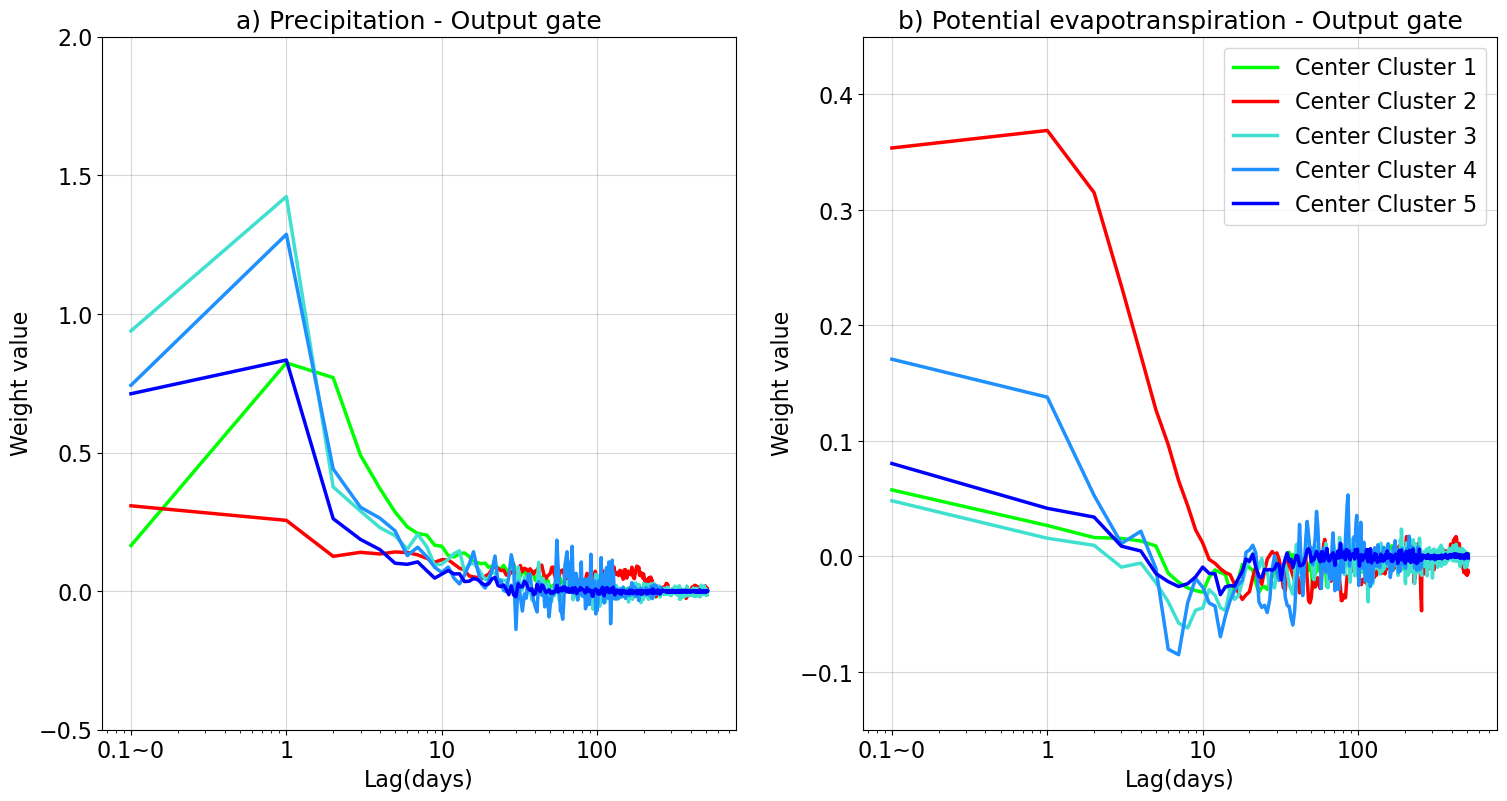

In [9]:

# Set the figure size
plt.figure(figsize=(18, 9))

# Count the number of elements in each cluster
_, n_elements = np.unique(Kmean_labels, return_counts=True)
print('Members per cluster:', n_elements)

# Define colors for clusters
colors_clusters = {
    0: 'lime',
    1: 'red',
    2: 'turquoise',
    3: 'dodgerblue',
    4: 'blue',
    #5: 'blue'
}

# Define labels for cluster centers
labels = {
    0: 'Center Cluster 1',
    1: 'Center Cluster 2',
    2: 'Center Cluster 3',
    3: 'Center Cluster 4',
    4: 'Center Cluster 5',
    #5: 'Center Cluster 6'
}

# Define positions for colors
cluster_position = {
    0: 1,   # cluster name: color position 
    1: 2,
    2: 3,
    3: 0,
    4: 4,
    5: 5
}

# Define line styles
line_styles = ['-'] * 10
alpha = 1

# Define titles for subplots
titles = ['Precipitation - Forget gate', 'Potential evapotranspiration - Forget gate',
          'Precipitation - Input gate', 'Potential evapotranspiration - Input gate',
          'a) Precipitation - Output gate', 'b) Potential evapotranspiration - Output gate']

k = 0
# Iterate over the range to create subplots
for i in range(4, 6):
    plt.subplot(1, 2, i - 3)
    # Iterate over clusters
    for j in range(n_clusters):
        z = cluster_position[j]
        # Plot if the number of elements in the cluster is greater than 10
        if n_elements[j] > 10:
            x_values = np.arange(513, dtype=float)
            x_values[0] = 0.1
            plt.semilogx(x_values, Kmean_cluster[cluster_position[j], (513 * i):513 * (i + 1)],
                         linewidth=2.5, linestyle=line_styles[j], color=colors_clusters[j], alpha=alpha,
                         label=labels[j])  # semilogx
    # Add grid
    plt.grid(alpha=0.5)
    plt.ylabel('Weight value', fontsize=16)
    plt.xlabel('Lag(days)', fontsize=16)
    # Set ylim based on the value of k
    if k == 0:
        plt.ylim(-0.5, 2)
        k = 1
    else:
        plt.ylim(-0.15, 0.45)
        k = 0
    plt.title(titles[i], fontsize=18)
    # Add legend for the last subplot
    if i == 5:
        plt.legend(fontsize=16)
    # Set ticks and labels for x and y axes
    plt.xticks([0.1, 1, 10, 100], ["0.1~0", 1, 10, 100], fontsize=16)
    plt.yticks(fontsize=16)

# Save the plot
plt.savefig('Fig 2 Center cluster in output gate.jpg', bbox_inches="tight")

# S1 Cluster center in all the gates

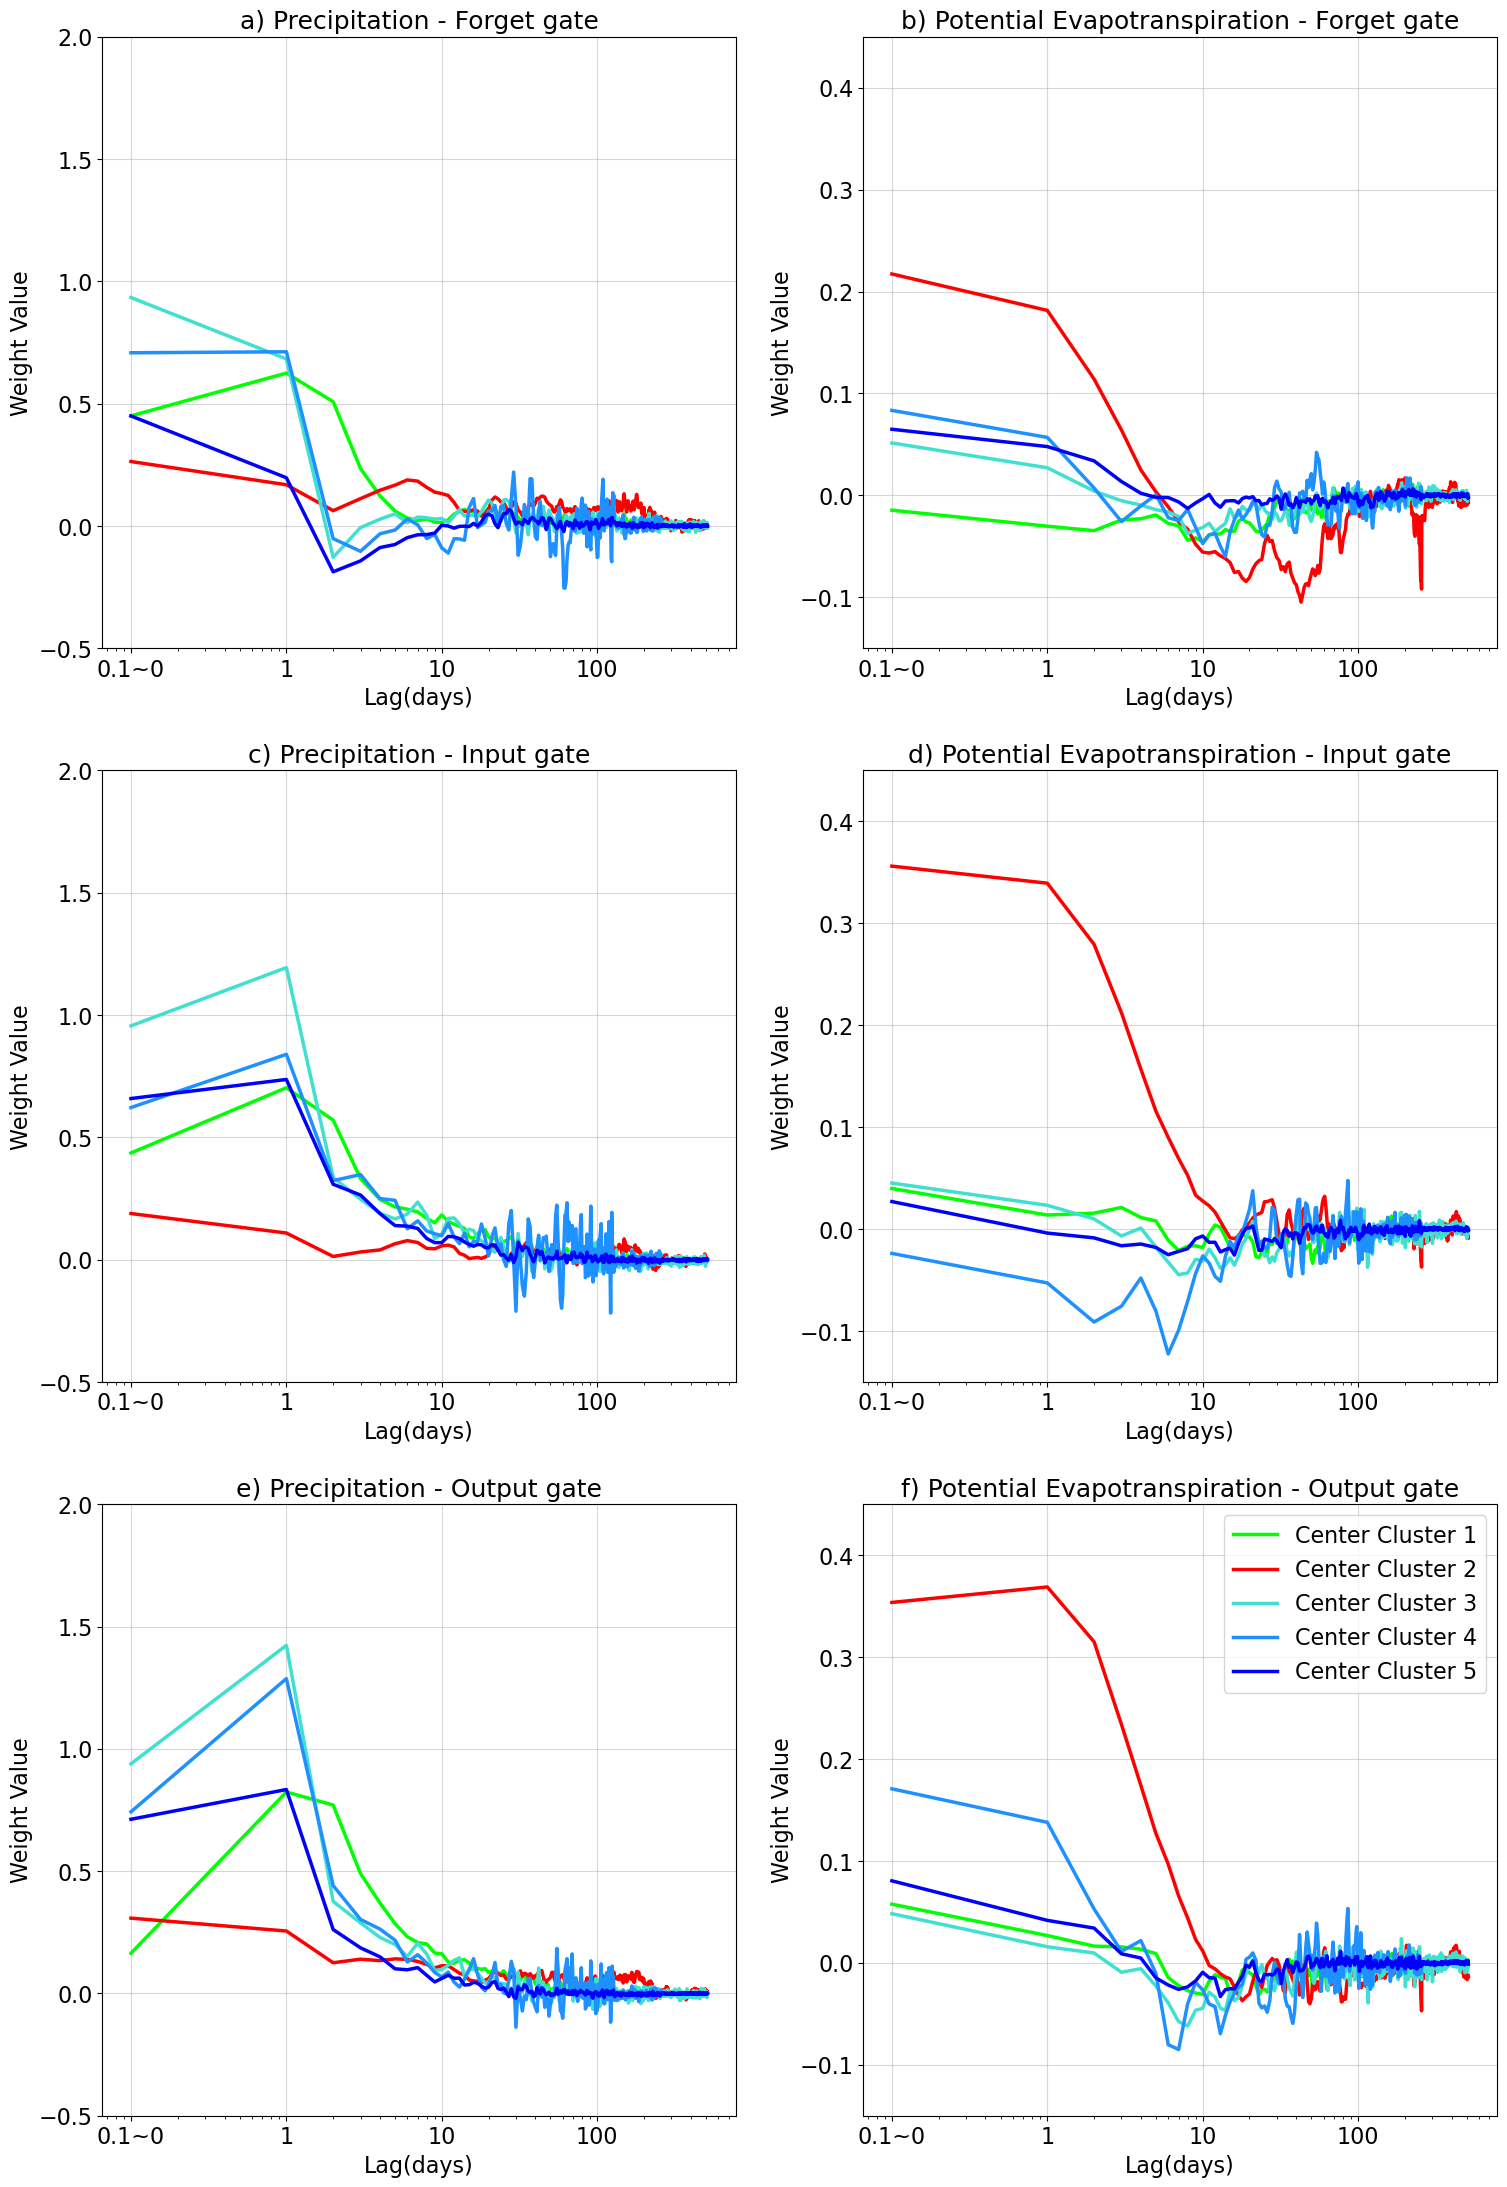

In [10]:
# Set titles for each subplot
title = ['a) Precipitation - Forget gate', 'b) Potential Evapotranspiration - Forget gate',
         'c) Precipitation - Input gate', 'd) Potential Evapotranspiration - Input gate',
         'e) Precipitation - Output gate', 'f) Potential Evapotranspiration - Output gate']

# Set the figure size
plt.figure(figsize=(18, 27))

# Initialize k
k = 0

# Iterate over each subplot
for i in range(6):
    plt.subplot(3, 2, i + 1)
    # Iterate over each cluster
    for j in range(n_clusters):
        z = cluster_position[j]
        # Plot if the number of elements in the cluster is greater than 10
        if n_elements[j] > 10:
            x_values = np.arange(513, dtype=float)
            x_values[0] = 0.1
            plt.semilogx(x_values, Kmean_cluster[cluster_position[j], (513 * i):513 * (i + 1)],
                         linewidth=2.5, linestyle=line_styles[j], color=colors_clusters[j], alpha=alpha,
                         label=labels[j])  # semilogx
    # Add grid
    plt.grid(alpha=0.5)
    plt.ylabel('Weight Value', fontsize=16)
    plt.xlabel('Lag(days)', fontsize=16)
    # Set ylim based on the value of k
    if k == 0:
        plt.ylim(-0.5, 2)
        k = 1
    else:
        plt.ylim(-0.15, 0.45)
        k = 0
    plt.title(title[i], fontsize=18)
    # Add legend for the last subplot
    if i == 5:
        plt.legend(fontsize=16)
    # Set ticks and labels for x and y axes
    plt.xticks([0.1, 1, 10, 100], ["0.1~0", 1, 10, 100], fontsize=16)
    plt.yticks(fontsize=16)

# Save the plot
plt.savefig('Fig S1 Center cluster in the gates.jpg', bbox_inches="tight")


# Fig 3 Dominant cluster per catchment

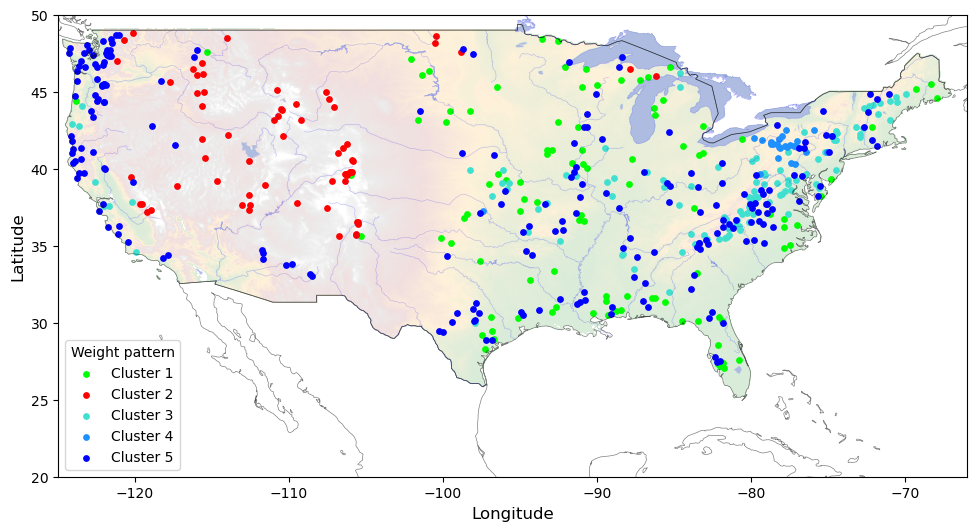

In [11]:
# Define the path to the attribute file and read it into a DataFrame
path = current_dir
attr_path = path + '/' + 'gauge_information.csv'
attr = pd.read_csv(attr_path)
# Set the 'GAGE_ID' as the index
attr.set_index('GAGE_ID', inplace=True)

# Define the path to the list of gauge IDs and read it into a DataFrame
list_path = path + '/' + 'list_IDs_all.csv'
geo_list = pd.read_csv(list_path)
geo_list.index = geo_list['GAGE_ID'].values

# Add latitude, longitude, and area information to the geo_list DataFrame
geo_list['Lat'] = attr.LAT
geo_list['Long'] = attr.LONG
geo_list['Area'] = attr.area

# Filter geo_list to only include stations with KGE_best greater than KGE_lim
geo_list = geo_list.loc[df_list_C1_no_reg.KGE_best > KGE_lim]
# Add cluster information to geo_list
geo_list['Cluster'] = Kmean_labels

# Add latitude, longitude, and cluster information to df_list_C1_no_reg
df_list_C1_no_reg['Lat'] = geo_list.Lat
df_list_C1_no_reg['Long'] = geo_list.Long
df_list_sel = df_list_C1_no_reg[df_list_C1_no_reg.KGE_best > KGE_lim]
df_list_sel['Cluster'] = Kmean_labels

# Read shapefiles for continent, drainage network, and lakes
df_continent = geopandas.read_file(current_dir + '/shp/Americas.shp')
df_drainage_network = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Hidrografia.shp')
df_lakes = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Lagos.shp')

# Read elevation data
fp = current_dir + '/elevation.tif'
img = rasterio.open(fp, 'r')

# Define color values and corresponding colors for the elevation map
cvals = [-11, 0, 500, 1000, 2000, 3000]
colors = ["white", "green", "orange", "brown", "gray", "white"]
norm_blue = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm_blue, cvals), colors))
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

# Read MOPEX data
MOPEX = pd.read_csv(current_dir + '/MOPEX160_Jiang.csv')

# Create a plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
df_continent.boundary.plot(color='black', ax=ax, lw=0.5, alpha=0.5)
df_drainage_network.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
df_lakes.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlim([-125, -66])
ax.set_ylim([20, 50])

# Define marker styles and labels for clusters
markers_cluster = {0: 'o',
                   1: 'o',
                   2: 'o',
                   3: 'o',
                   4: 'o',
                   }
                                      
labels = {0: 'Cluster 1',
          1: 'Cluster 2',
          2: 'Cluster 3',
          3: 'Cluster 4',
          4: 'Cluster 5'
          }

# Plot the clusters
for i in range(5):
    ax.scatter(df_list_sel.Long[(df_list_sel.Cluster == cluster_position[i])],
               df_list_sel.Lat[(df_list_sel.Cluster == cluster_position[i])],
               marker=markers_cluster[i],
               s=15,
               color=colors_clusters[i],
               label=labels[i])

# Show the elevation map with transparency
show((img, 1), ax=ax, cmap=cmap_blue, norm=norm_blue, alpha=0.15)

# Add a legend
ax.legend(title="Weight pattern")

# Save the plot
plt.savefig('Fig 3 Comparison.jpg', bbox_inches="tight")


# Fig.4 Perfomance comparison

In [12]:
# Define the path to the model
file_model = parent_dir + '/Results' + '/RF_mean/1000000_C1_L512_regionalhydro_RF_model.pkl'

# Load the model using pickle
try:
    with open(file_model, 'rb') as f:
        RF_model = pickle.load(f)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file {file_model} was not found.")
except pickle.UnpicklingError:
    print("Error: The file could not be unpickled.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Model loaded successfully.


In [13]:

# Define the path to the LSTM model results
LSTM_path = os.path.join(parent_dir + '/Results', 'neuralhydrology/runs/cudalstm_569_basins_0403_113038/test/model_epoch025/test_results.p')

# Load the results using pickle
try:
    with open(LSTM_path, 'rb') as f:
        LSTM_model = pickle.load(f)
    print("LSTM model results loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file {LSTM_path} was not found.")
except pickle.UnpicklingError:
    print("Error: The file could not be unpickled.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

LSTM model results loaded successfully.


In [14]:
print('Reading KGE for Local HydroLSTM:')
df_list_C1_no_reg['KGE_testing'] = -999

# Loop through each code and read the KGE value from the corresponding CSV file
for code in tqdm(list_codes):
    try:
        file_path = os.path.join(parent_dir + '/Results', 'hydroLSTM/best model', f'{code}_C1_L{int(df_summary.loc[code])}_hydro_summary_testing.csv')
        summary_KGE = pd.read_csv(file_path)
        df_list_C1_no_reg.at[code, 'KGE_testing'] = summary_KGE['KGE_testing'].values[0]
    except FileNotFoundError:
        print(f"File not found for code: {code}")
    except pd.errors.EmptyDataError:
        print(f"Empty data in file for code: {code}")
    except Exception as e:
        print(f"An error occurred for code {code}: {e}")

# Sort the KGE values
df_list_C1_no_reg_sort = np.sort(df_list_C1_no_reg['KGE_testing'].values)


Reading KGE for Local HydroLSTM:


100%|████████████████████████████████████████| 569/569 [00:00<00:00, 819.18it/s]


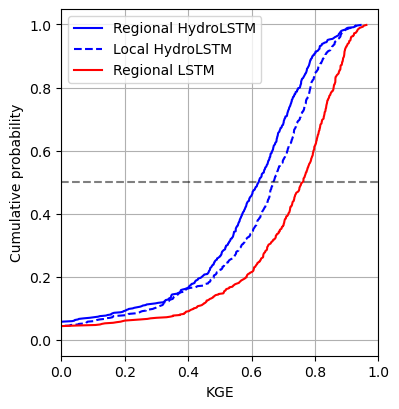

In [15]:
# Paths to your data files
RF_path = parent_dir + '/Results' + '/RF_mean/1000000_C1_L512_regionalhydro_summary_per_catchment_testing.csv'
LSTM_path = parent_dir + '/Results' + '/neuralhydrology/runs/cudalstm_569_basins_0403_113038/test/model_epoch025/test_metrics.csv'

# Load and process the Regional HydroLSTM data
RF_mean = pd.read_csv(RF_path)
RF_mean.index = RF_mean.code
df_list_RF_reg_sort = np.sort(RF_mean.KGE_testing.values)

# Load and process the Regional LSTM data
LSTM_model = pd.read_csv(LSTM_path)
LSTM_sort = np.sort(LSTM_model.KGE.values)
x_sort = np.arange(len(LSTM_sort)) / len(LSTM_sort)

# Assuming df_list_C1_no_reg_sort has already been computed as shown in previous steps
# df_list_C1_no_reg_sort = np.sort(df_list_C1_no_reg.KGE_testing.values)

# Plot the KGE values for different models
plt.figure(figsize=(9,4.5))

# Plot for Regional HydroLSTM
plt.subplot(1, 2, 1)
plt.plot(df_list_RF_reg_sort, np.arange(len(RF_mean)) / len(RF_mean), '-b', label='Regional HydroLSTM')

# Plot for Local HydroLSTM
plt.plot(df_list_C1_no_reg_sort, np.arange(len(df_list_C1_no_reg_sort)) / len(df_list_C1_no_reg_sort), '--b', label='Local HydroLSTM')

# Plot for Regional LSTM
plt.plot(LSTM_sort, x_sort, '-r', label='Regional LSTM')

# Add reference line at 0.5 cumulative probability
plt.plot([0, 1], [0.5, 0.5], 'k--', alpha=0.5)

# Set plot limits and labels
plt.xlim(0, 1)
plt.grid()
plt.legend()
plt.xlabel('KGE')
plt.ylabel('Cumulative probability')

# Save the figure
plt.savefig('Fig 4 Performance comparison.jpg', bbox_inches="tight")

plt.show()

# S2 Variability capture by RF model

In [16]:
# Define the file path to the CSV file containing the Random Forest model weights
RF_weight_path = parent_dir + '/Results' + '/RF_mean/1000000_C1_L512_regionalhydro_weights.csv'

# Read the CSV file into a pandas DataFrame
# Set the 'GAGE_ID' column as the index of the DataFrame
RF_mean_weight = pd.read_csv(RF_weight_path, index_col='GAGE_ID')


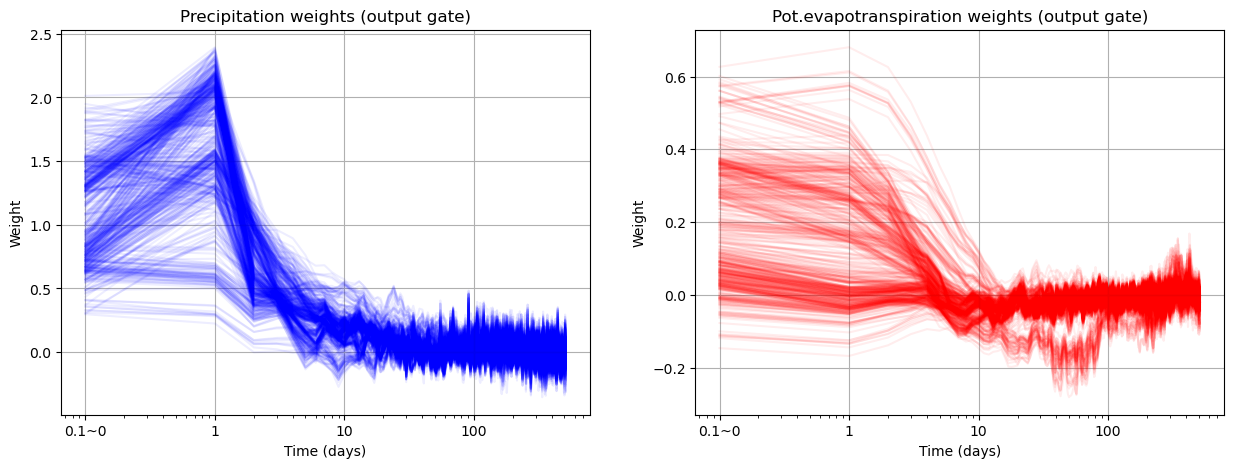

In [17]:
# Create a new figure with specified size
plt.figure(figsize=(15,5))

# Define x_values for plotting, with a logarithmic scale starting from 0.1
x_values = np.arange(513, dtype=float)
x_values[0] = 0.1

# Create the first subplot for Precipitation weights (output gate)
plt.subplot(1,2,1)
# Plot the Precipitation weights for each row in RF_mean_weight DataFrame with semi-transparent blue lines
for i in range(len(RF_mean_weight)):
    plt.semilogx(x_values, RF_mean_weight.iloc[i, 2052+0:3078-513], '-b', alpha=0.07)
# Add grid lines for better readability
plt.grid()
# Set the title, x-axis label, y-axis label, and x-axis tick labels
plt.title('Precipitation weights (output gate)')
plt.xlabel('Time (days)')
plt.ylabel('Weight')
plt.xticks([0.1,1,10,100], ["0.1~0",1,10,100], fontsize=10)

# Create the second subplot for Potential Evapotranspiration weights (output gate)
plt.subplot(1,2,2)
# Plot the Potential Evapotranspiration weights for each row in RF_mean_weight DataFrame with semi-transparent red lines
for i in range(len(RF_mean_weight)):
    plt.semilogx(x_values, RF_mean_weight.iloc[i, 2052+513:3078-0], '-r', alpha=0.07)
# Add grid lines for better readability
plt.grid()
# Set the title, x-axis label, y-axis label, and x-axis tick labels
plt.title('Pot.evapotranspiration weights (output gate)')
plt.xlabel('Time (days)')
plt.ylabel('Weight')
plt.xticks([0.1,1,10,100], ["0.1~0",1,10,100], fontsize=10)

# Save the figure with the specified filename and adjust bounding box
plt.savefig('Fig S2 variability of the weight pattern.jpg', bbox_inches="tight")


# Fig5 Feature importance of RF model

In [18]:
# Construct the path to the Random Forest (RF) model file by concatenating the current_path with the directory and file name
file_model = parent_dir + '/Results' + '/RF_mean' + '/1000000_C1_L512_regionalhydro_RF_model.pkl'

# Load the RF model from the specified file using pickle
RF_model = pickle.load(open(file_model, "rb" ))


In [19]:
RF_model

RandomForestRegressor(max_features=0.8, n_estimators=400, n_jobs=-1,
                      oob_score=True)

In [20]:
# Calculate feature importances and standard deviations from the Random Forest model
importances = RF_model.feature_importances_
std_dev = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)

# Convert numpy arrays to pandas Series
importances = pd.Series(importances)
std_dev = pd.Series(std_dev)

# Create DataFrame from the existing series with feature importances and standard deviations
forest_importances = pd.DataFrame({'importances': importances, 'std_dev': std_dev})

# Set the index of the DataFrame to feature names
forest_importances.index = RF_model.feature_names_in_

# Sort the DataFrame by feature importances
forest_importances = forest_importances.sort_values(by='importances')


In [21]:
forest_importances

importances   std_dev
water_frac               0.001254  0.001632
carbonate                0.006128  0.003329
area                     0.010610  0.004864
geol_permeability        0.010893  0.004801
sand_frac                0.014694  0.009492
gvf_max                  0.024598  0.019412
lai_max                  0.029040  0.030273
soil_conductivity        0.029435  0.012275
clay_frac                0.031896  0.016841
soil_depth_pelletier     0.036715  0.037911
lai_diff                 0.042473  0.039198
frac_forest              0.052969  0.017985
p_mean                   0.078130  0.024886
gvf_diff                 0.094843  0.031756
slope_mean               0.121329  0.031030
pet_mean                 0.137565  0.023838
elev_mean                0.277427  0.051833

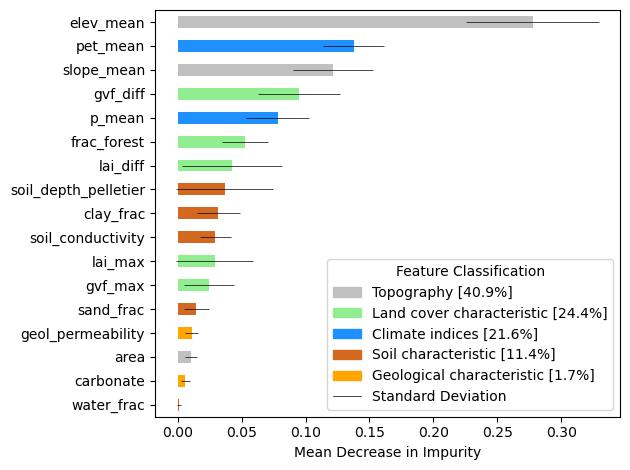

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Your list of colors and corresponding feature names
colors = ['chocolate', 'orange', 'silver', 'orange', 'chocolate', 'lightgreen', 
          'lightgreen', 'chocolate', 'chocolate', 'chocolate', 'lightgreen', 
          'lightgreen', 'dodgerblue', 'lightgreen', 'silver', 'dodgerblue', 
          'silver']

colors_unique =  ['silver','lightgreen','dodgerblue', 'chocolate','orange']
feature_labels = [ 'Topography [40.9%]', 
                  'Land cover characteristic [24.4%]',
                  'Climate indices [21.6%]',
                  'Soil characteristic [11.4%]',
                  'Geological characteristic [1.7%]'
                 ]

    
    


# Create a horizontal bar plot to visualize feature importances with error bars
fig, ax = plt.subplots()
forest_importances.importances.plot.barh(xerr=forest_importances.std_dev,
                                         ax=ax,
                                         color=colors,
                                         error_kw=dict(label='Standard Deviation', capsize=0, capthick=1, elinewidth=0.5),
                                         label='Importance')

# Set labels
ax.set_xlabel("Mean Decrease in Impurity")
fig.tight_layout()

# Create a custom legend for the bars
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors_unique, feature_labels)]

# Create a custom legend for the error bars with the same style
error_handle = mlines.Line2D([], [], color='black', linestyle='-', linewidth=0.5, 
                             marker='', markersize=8, label='Standard Deviation', 
                             markeredgewidth=1.5)

# Combine the handles
handles.append(error_handle)
labels = feature_labels + ['Standard Deviation']

# Add legend
ax.legend(handles, labels, title="Feature Classification")




# Save the plot as an image
plt.savefig('Fig 5 Feature importance of RF model in the regional HydroLSTM.jpg', bbox_inches="tight")



# Fig6 Feature importance of RF model simplified

In [23]:
seed = 20

OOB score = 0.9257179082831265
OOB score = 0.8760976505815786


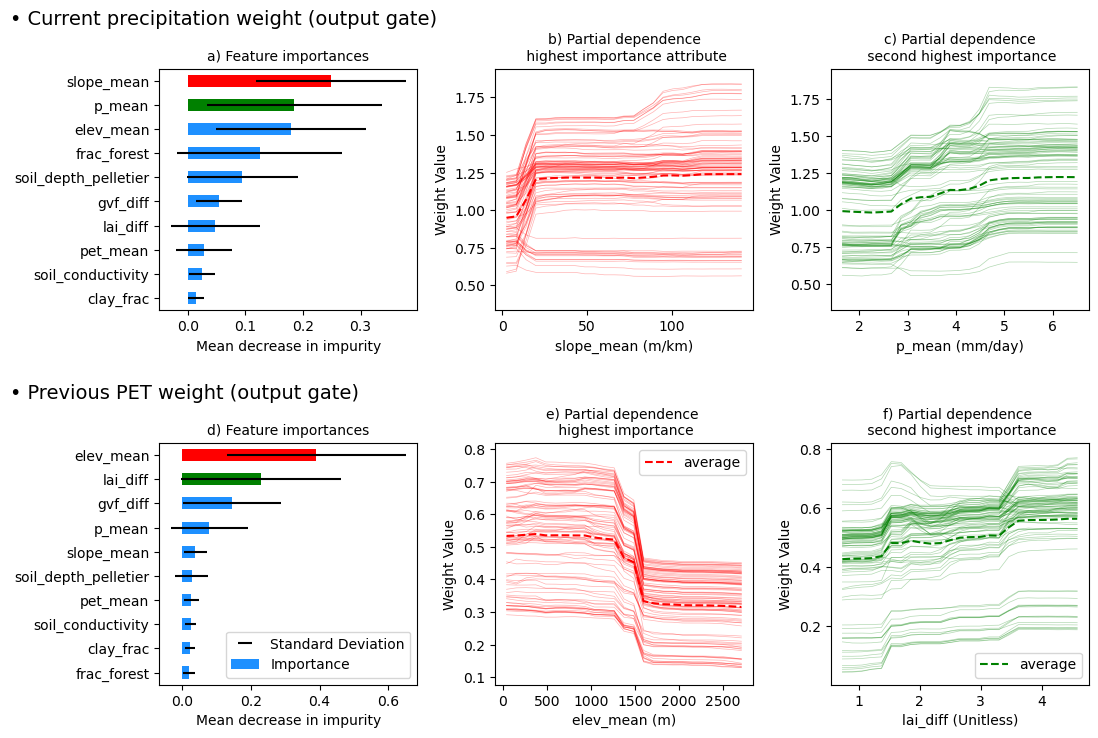

In [24]:
# Import pandas library for data manipulation
code_list = pd.read_csv('list.csv')  # Read CSV file containing code list into DataFrame

# Read CSV file with gauge information into DataFrame and set 'GAGE_ID' as the index
code_att = pd.read_csv('gauge_information2.csv', index_col='GAGE_ID')

# Select rows in code_att that are also in the index of RF_mean_weight
code_att = code_att.loc[RF_mean_weight.index]

# Keep only the specified columns related to various geographical and meteorological attributes
code_att = code_att[['elev_mean','slope_mean','frac_forest','lai_diff','gvf_diff','p_mean','pet_mean','clay_frac','soil_depth_pelletier','soil_conductivity']]

# Filter rows where the 'KGE_testing' column in RF_mean is greater than KGE_lim
code_att = code_att[RF_mean.KGE_testing > KGE_lim]

# Select the same rows from RF_mean_weight where 'KGE_testing' in RF_mean is greater than KGE_lim
RF_mean_weight_sel = RF_mean_weight[RF_mean.KGE_testing > KGE_lim]

# Select only the specified column (2052) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [2052]]  # Columns can be: 2052, 2053, 2063, 3079

# Initialize a RandomForestRegressor model with specific parameters
simple_model = RandomForestRegressor(
    n_estimators=200,          # Number of trees in the forest
    bootstrap=True,            # Whether bootstrap samples are used when building trees
    max_depth=None,            # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples)
    max_features=0.5,          # Number of features to consider when looking for the best split
    min_samples_split=4,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 means using all processors)
    oob_score=True,            # Whether to use out-of-bag samples to estimate the generalization accuracy
    random_state=seed          # Seed used by the random number generator
)

# Train the RandomForestRegressor model using code_att as features and RF_mean_weight_simpl as target
simple_model.fit(code_att, RF_mean_weight_simpl)

# Print the out-of-bag score, which is an estimate of the model's generalization accuracy
print('OOB score =', simple_model.oob_score_)

# Get feature importances from the trained model
importances = simple_model.feature_importances_

# Calculate the standard deviation of feature importances across all trees in the forest
std_dev = np.std([tree.feature_importances_ for tree in simple_model.estimators_], axis=0)

# Convert numpy arrays to pandas Series
importances = pd.Series(importances)
std_dev = pd.Series(std_dev)

# Create DataFrame from the existing series
forest_importances = pd.DataFrame({'importances': importances, 'std_dev': std_dev})
forest_importances.index = simple_model.feature_names_in_
forest_importances = forest_importances.sort_values(by='importances')

# Create a figure and a set of subplots with 3 columns and 2 rows
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), constrained_layout=True, gridspec_kw={'hspace': 0.55})

# Define a list of colors for the bar plot
color = ['dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'green', 'red']

# Plot feature importances with standard deviation error bars on the first subplot (top-left)
forest_importances.importances.plot.barh(
    xerr=forest_importances.std_dev,      # Add error bars
    ax=ax[0, 0],                          # Specify subplot to plot on
    color=color,                          # Set bar colors
    error_kw=dict(label='std. dev.'),     # Error bar configuration
    label='importance'                    # Label for the plot
)

# Set title and x-axis label for the first subplot
ax[0, 0].set_title("a) Feature importances", fontsize=10)
ax[0, 0].set_xlabel("Mean decrease in impurity")

# Adjust layout to prevent overlap
fig.tight_layout()

# Define common parameters for partial dependence plots
common_params = {
    "subsample": 100,         # Subsample size for efficiency
    "n_jobs": -1,             # Use all processors
    "grid_resolution": 25,    # Resolution of the grid
    "random_state": 0,        # Seed for random number generator
}

# Create a partial dependence plot for 'slope_mean' on the second subplot (top-middle)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['slope_mean'],   # Feature to plot
    kind="both",               # Plot both individual and average effects
    ax=ax[0, 1],               # Specify subplot to plot on
    **common_params,           # Apply common parameters
)

# Remove the legend from the plot
display.axes_[0, 0].legend_.remove()

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("slope_mean (m/km)")

# Set color of lines in the partial dependence plot to red
for line in display.axes_[0, 0].lines:
    line.set_color('red')

# Set title for the second subplot
ax[0, 1].set_title("b) Partial dependence\n highest importance attribute", fontsize=10)

# Add text annotation above the second subplot
ax[0, 1].text(-1.05, 1.0, "• Current precipitation weight (output gate)\n \n", ha='center', fontsize=14, transform=ax[0, 1].transAxes)

# Create a partial dependence plot for 'p_mean' on the third subplot (top-right)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['p_mean'],       # Feature to plot
    kind="both",               # Plot both individual and average effects
    ax=ax[0, 2],               # Specify subplot to plot on
    **common_params,           # Apply common parameters
)

# Remove the legend from the plot
display.axes_[0, 0].legend_.remove()

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("p_mean (mm/day)")

# Set color of lines in the partial dependence plot to green
for line in display.axes_[0, 0].lines:
    line.set_color('green')

# Set title for the third subplot
ax[0, 2].set_title("c) Partial dependence\n second highest importance", fontsize=10)


# ----------------------------------------------------------------------------------------------------------------------------------------

# Select only the specified column (3079) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [3079]]  # Columns can be: 2052, 2053, 2063, 3079

# Initialize a RandomForestRegressor model with specific parameters
simple_model = RandomForestRegressor(
    n_estimators=200,          # Number of trees in the forest
    bootstrap=True,            # Whether bootstrap samples are used when building trees
    max_depth=None,            # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples)
    max_features=0.5,          # Number of features to consider when looking for the best split
    min_samples_split=4,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 means using all processors)
    oob_score=True,            # Whether to use out-of-bag samples to estimate the generalization accuracy
    random_state=seed          # Seed used by the random number generator
)

# Train the RandomForestRegressor model using code_att as features and RF_mean_weight_simpl as target
simple_model.fit(code_att, RF_mean_weight_simpl)

# Print the out-of-bag score, which is an estimate of the model's generalization accuracy
print('OOB score =', simple_model.oob_score_)

# Get feature importances from the trained model
importances = simple_model.feature_importances_

# Calculate the standard deviation of feature importances across all trees in the forest
std_dev = np.std([tree.feature_importances_ for tree in simple_model.estimators_], axis=0)


# Convert numpy arrays to pandas Series
importances = pd.Series(importances)
std_dev = pd.Series(std_dev)

# Create DataFrame from the existing series
forest_importances = pd.DataFrame({'importances': importances, 'std_dev': std_dev})
forest_importances.index = simple_model.feature_names_in_
forest_importances = forest_importances.sort_values(by='importances')

# Plot feature importances with standard deviation error bars on the fourth subplot (bottom-left)
forest_importances.importances.plot.barh(
    xerr=forest_importances.std_dev,      # Add error bars
    ax=ax[1, 0],                          # Specify subplot to plot on
    color=color,                          # Set bar colors
    error_kw=dict(label='Standard Deviation'),  # Error bar configuration
    label='Importance'                    # Label for the plot
)

# Set title and x-axis label for the fourth subplot
ax[1, 0].set_title("d) Feature importances", fontsize=10)
ax[1, 0].set_xlabel("Mean decrease in impurity")

# Add a legend to the fourth subplot
ax[1, 0].legend()

# Define common parameters for partial dependence plots
common_params = {
    "subsample": 100,         # Subsample size for efficiency
    "n_jobs": -1,             # Use all processors
    "grid_resolution": 25,    # Resolution of the grid
    "random_state": 0,        # Seed for random number generator
}

# Create a partial dependence plot for 'elev_mean' on the fifth subplot (bottom-middle)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['elev_mean'],   # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[1, 1],              # Specify subplot to plot on
    line_kw={"color": "red"}, # Set line color to red
    **common_params,          # Apply common parameters
)

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("elev_mean (m)")

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Set title for the fifth subplot
ax[1, 1].set_title("e) Partial dependence \n highest importance", fontsize=10)

# Add text annotation above the fifth subplot
ax[1, 1].text(-1.2, 1.00, "• Previous PET weight (output gate)\n \n", ha='center', fontsize=14, transform=ax[1, 1].transAxes)

# Create a partial dependence plot for 'lai_diff' on the sixth subplot (bottom-right)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['lai_diff'],    # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[1, 2],              # Specify subplot to plot on
    line_kw={"color": "green"}, # Set line color to green
    **common_params,          # Apply common parameters
)

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("lai_diff (Unitless)")

# Set title for the sixth subplot
ax[1, 2].set_title("f) Partial dependence \n second highest importance", fontsize=10)

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.3)

# Save the figure as a JPEG file with tight bounding box
plt.savefig('Fig 6 partial dependence.jpg', bbox_inches="tight")


## S3 Feature importance of RF model

OOB score = 0.9682203750029568
OOB score = 0.879221506216053


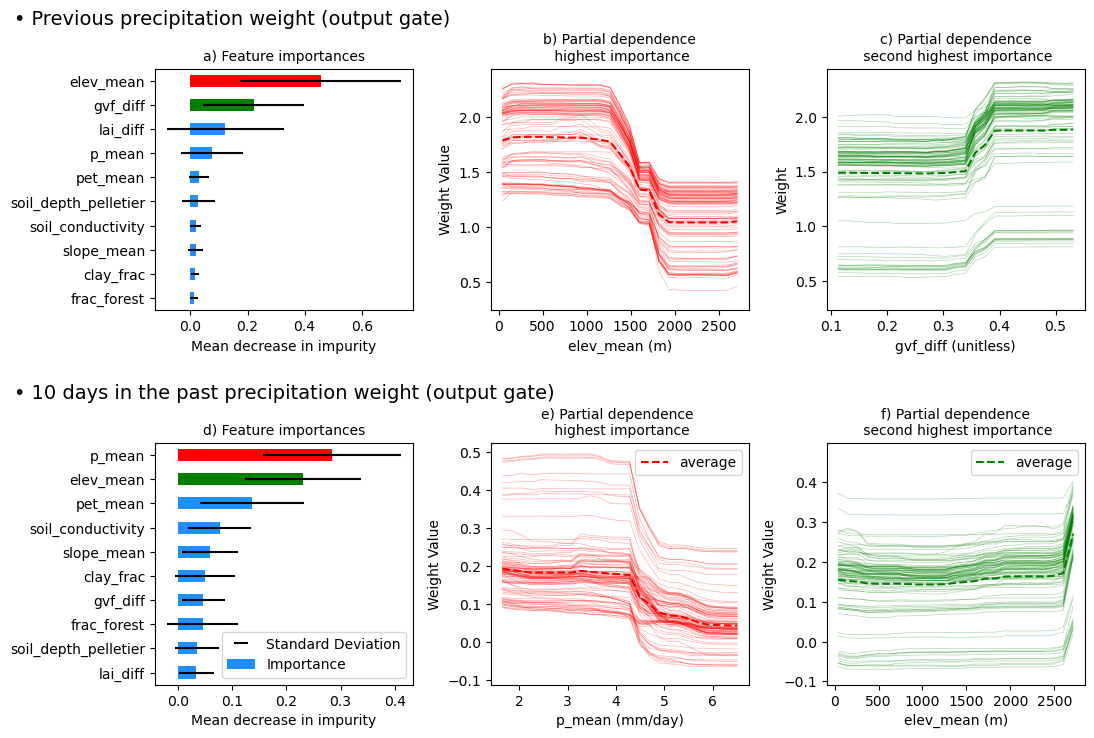

In [25]:
# Import pandas library for data manipulation
code_list = pd.read_csv('list.csv')  # Read CSV file containing code list into DataFrame

# Read CSV file with gauge information into DataFrame and set 'GAGE_ID' as the index
code_att = pd.read_csv('gauge_information2.csv', index_col='GAGE_ID')

# Select rows in code_att that are also in the index of RF_mean_weight
code_att = code_att.loc[RF_mean_weight.index]

# Keep only the specified columns related to various geographical and meteorological attributes
code_att = code_att[['elev_mean', 'slope_mean', 'frac_forest', 'lai_diff', 'gvf_diff', 'p_mean', 'pet_mean', 'clay_frac', 'soil_depth_pelletier', 'soil_conductivity']]

# Filter rows where the 'KGE_testing' column in RF_mean is greater than KGE_lim
code_att = code_att[RF_mean.KGE_testing > KGE_lim]

# Select the same rows from RF_mean_weight where 'KGE_testing' in RF_mean is greater than KGE_lim
RF_mean_weight_sel = RF_mean_weight[RF_mean.KGE_testing > KGE_lim]

# Select only the specified column (2053) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [2053]]  # Columns can be: 2052, 2053, 2063, 3079

# Initialize a RandomForestRegressor model with specific parameters
simple_model = RandomForestRegressor(
    n_estimators=200,          # Number of trees in the forest
    bootstrap=True,            # Whether bootstrap samples are used when building trees
    max_depth=None,            # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples)
    max_features=0.5,          # Number of features to consider when looking for the best split
    min_samples_split=4,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 means using all processors)
    oob_score=True,            # Whether to use out-of-bag samples to estimate the generalization accuracy
    random_state=seed          # Seed used by the random number generator
)

# Train the RandomForestRegressor model using code_att as features and RF_mean_weight_simpl as target
simple_model.fit(code_att, RF_mean_weight_simpl)

# Print the out-of-bag score, which is an estimate of the model's generalization accuracy
print('OOB score =', simple_model.oob_score_)

# Get feature importances from the trained model
importances = simple_model.feature_importances_

# Calculate the standard deviation of feature importances across all trees in the forest
std_dev = np.std([tree.feature_importances_ for tree in simple_model.estimators_], axis=0)

# Convert numpy arrays to pandas Series
importances = pd.Series(importances)
std_dev = pd.Series(std_dev)

# Create DataFrame from the existing series
forest_importances = pd.DataFrame({'importances': importances, 'std_dev': std_dev})
forest_importances.index = simple_model.feature_names_in_
forest_importances = forest_importances.sort_values(by='importances')

# Create a figure and a set of subplots with 3 columns and 2 rows
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), constrained_layout=True, gridspec_kw={'hspace': 0.55})

# Define a list of colors for the bar plot
color = ['dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'green', 'red']

# Plot feature importances with standard deviation error bars on the first subplot (top-left)
forest_importances.importances.plot.barh(
    xerr=forest_importances.std_dev,      # Add error bars
    ax=ax[0, 0],                          # Specify subplot to plot on
    color=color,                          # Set bar colors
    error_kw=dict(label='std. dev.'),     # Error bar configuration
    label='importance'                    # Label for the plot
)

# Set title and x-axis label for the first subplot
ax[0, 0].set_title("a) Feature importances", fontsize=10)
ax[0, 0].set_xlabel("Mean decrease in impurity")

# Adjust layout to prevent overlap
fig.tight_layout()

# Define common parameters for partial dependence plots
common_params = {
    "subsample": 100,         # Subsample size for efficiency
    "n_jobs": -1,             # Use all processors
    "grid_resolution": 25,    # Resolution of the grid
    "random_state": 0,        # Seed for random number generator
}

# Create a partial dependence plot for 'elev_mean' on the second subplot (top-middle)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['elev_mean'],   # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[0, 1],              # Specify subplot to plot on
    **common_params,          # Apply common parameters
)

# Remove the legend from the plot
display.axes_[0, 0].legend_.remove()

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("elev_mean (m)")

# Set color of lines in the partial dependence plot to red
for line in display.axes_[0, 0].lines:
    line.set_color('red')

# Set title for the second subplot
ax[0, 1].set_title("b) Partial dependence\n highest importance", fontsize=10)

# Add text annotation above the second subplot
ax[0, 1].text(-1.0, 1.00, "• Previous precipitation weight (output gate)\n \n", ha='center', fontsize=14, transform=ax[0, 1].transAxes)

# Create a partial dependence plot for 'gvf_diff' on the third subplot (top-right)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['gvf_diff'],    # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[0, 2],              # Specify subplot to plot on
    **common_params,          # Apply common parameters
)

# Remove the legend from the plot
display.axes_[0, 0].legend_.remove()

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight')

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("gvf_diff (unitless)")

# Set color of lines in the partial dependence plot to green
for line in display.axes_[0, 0].lines:
    line.set_color('green')

# Set title for the third subplot
ax[0, 2].set_title("c) Partial dependence\n second highest importance", fontsize=10)

# ----------------------------------------------------------------------------------------------------------------------------------------

# Select only the specified column (2063) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [2063]]  # Columns can be: 2052, 2053, 2063, 3079

# Initialize a RandomForestRegressor model with specific parameters
simple_model = RandomForestRegressor(
    n_estimators=200,          # Number of trees in the forest
    bootstrap=True,            # Whether bootstrap samples are used when building trees
    max_depth=None,            # Maximum depth of the tree (None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples)
    max_features=0.5,          # Number of features to consider when looking for the best split
    min_samples_split=4,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 means using all processors)
    oob_score=True,            # Whether to use out-of-bag samples to estimate the generalization accuracy
    random_state=seed          # Seed used by the random number generator
)

# Train the RandomForestRegressor model using code_att as features and RF_mean_weight_simpl as target
simple_model.fit(code_att, RF_mean_weight_simpl)

# Print the out-of-bag score, which is an estimate of the model's generalization accuracy
print('OOB score =', simple_model.oob_score_)

# Get feature importances from the trained model
importances = simple_model.feature_importances_

# Calculate the standard deviation of feature importances across all trees in the forest
std_dev = np.std([tree.feature_importances_ for tree in simple_model.estimators_], axis=0)

# Convert numpy arrays to pandas Series
importances = pd.Series(importances)
std_dev = pd.Series(std_dev)

# Create DataFrame from the existing series
forest_importances = pd.DataFrame({'importances': importances, 'std_dev': std_dev})
forest_importances.index = simple_model.feature_names_in_
forest_importances = forest_importances.sort_values(by='importances')

# Plot feature importances with standard deviation error bars on the fourth subplot (bottom-left)
forest_importances.importances.plot.barh(
    xerr=forest_importances.std_dev,      # Add error bars
    ax=ax[1, 0],                          # Specify subplot to plot on
    color=color,                          # Set bar colors
    error_kw=dict(label='Standard Deviation'),  # Error bar configuration
    label='Importance'                    # Label for the plot
)

# Set title and x-axis label for the fourth subplot
ax[1, 0].set_title("d) Feature importances", fontsize=10)
ax[1, 0].set_xlabel("Mean decrease in impurity")

# Add a legend to the fourth subplot
ax[1, 0].legend()

# Define common parameters for partial dependence plots
common_params = {
    "subsample": 100,         # Subsample size for efficiency
    "n_jobs": -1,             # Use all processors
    "grid_resolution": 25,    # Resolution of the grid
    "random_state": 0,        # Seed for random number generator
}

# Create a partial dependence plot for 'p_mean' on the fifth subplot (bottom-middle)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['p_mean'],      # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[1, 1],              # Specify subplot to plot on
    line_kw={"color": "red"}, # Set line color to red
    **common_params,          # Apply common parameters
)

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("p_mean (mm/day)")

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Set title for the fifth subplot
ax[1, 1].set_title("e) Partial dependence \n highest importance", fontsize=10)

# Add text annotation above the fifth subplot
ax[1, 1].text(-0.8, 1.00, "• 10 days in the past precipitation weight (output gate)\n \n", ha='center', fontsize=14, transform=ax[1, 1].transAxes)

# Create a partial dependence plot for 'elev_mean' on the sixth subplot (bottom-right)
display = PartialDependenceDisplay.from_estimator(
    simple_model,
    code_att,
    features=['elev_mean'],   # Feature to plot
    kind="both",              # Plot both individual and average effects
    ax=ax[1, 2],              # Specify subplot to plot on
    line_kw={"color": "green"}, # Set line color to green
    **common_params,          # Apply common parameters
)

# Hide decile lines
plt.setp(display.deciles_vlines_, visible=False)

# Set x-axis label
plt.xlabel("elev_mean (m)")

# Set title for the sixth subplot
ax[1, 2].set_title("f) Partial dependence\n second highest importance", fontsize=10)

# Set y-axis label for the partial dependence plot
display.axes_[0, 0].set_ylabel('Weight Value')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.3)

# Save the figure as a JPEG file with tight bounding box
plt.savefig('Fig S3 partial dependence.jpg', bbox_inches="tight")


# Figure 7 Best desicion tree

# Select specific columns (2052, 2053, 2063, 3079) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [2052, 2053, 2063, 3079]]  
#RF_mean_weight_simpl = RF_mean_weight_sel.copy()  

## Initialize an empty list to store out-of-bag scores
#oob_list = []

## Initialize a RandomForestRegressor model with specific parameters
#simple_model = RandomForestRegressor(
#    n_estimators=200,          # Number of trees in the forest
#    bootstrap=True,            # Whether bootstrap samples are used when building trees
#    max_depth=6,               # Maximum depth of the tree
#    max_features=0.8,          # Number of features to consider when looking for the best split
#    oob_score=True             # Whether to use out-of-bag samples to estimate the generalization accuracy
#)

# Read CSV file with gauge information into DataFrame and set 'GAGE_ID' as the index
code_att = pd.read_csv('gauge_information2.csv', index_col='GAGE_ID')

# Select rows in code_att that are also in the index of RF_mean_weight
code_att = code_att.loc[RF_mean_weight.index]

# Filter rows where the 'KGE_testing' column in RF_mean is greater than KGE_lim
code_att = code_att[RF_mean.KGE_testing > KGE_lim]

# Keep only the specified columns related to various geographical and meteorological attributes
code_att = code_att[['elev_mean','slope_mean','frac_forest','lai_diff','gvf_diff','p_mean','pet_mean','clay_frac','soil_depth_pelletier','soil_conductivity']]

## Train the RandomForestRegressor model using code_att as features and RF_mean_weight_simpl as target
#simple_model.fit(code_att, RF_mean_weight_simpl)

## Predict the target values using the trained model
#pred_simple_model = simple_model.predict(code_att)


In [26]:
## Select specific columns (2052, 2053, 2063, 3079) from RF_mean_weight_sel
RF_mean_weight_simpl = RF_mean_weight_sel.iloc[:, [2052, 2053, 2063, 3079]]  # Columns can be: 2052, 2053, 2063, 3079

# Initialize a DecisionTreeRegressor model with specific parameters
simple_model = DecisionTreeRegressor(
    min_impurity_decrease=0.0004,  # Minimum impurity decrease required for a split
    splitter='best',               # Strategy used to choose the split at each node
    max_depth=6                    # Maximum depth of the tree
) 

# Train the DecisionTreeRegressor model using code_att as features and RF_mean_weight_simpl as target
simple_model.fit(code_att, RF_mean_weight_simpl)

# Print the R-squared score, which measures the proportion of the variance in the target variable that is predictable from the input variables
print('R2 score =', simple_model.score(code_att, RF_mean_weight_simpl))


R2 score = 0.9055697356508133


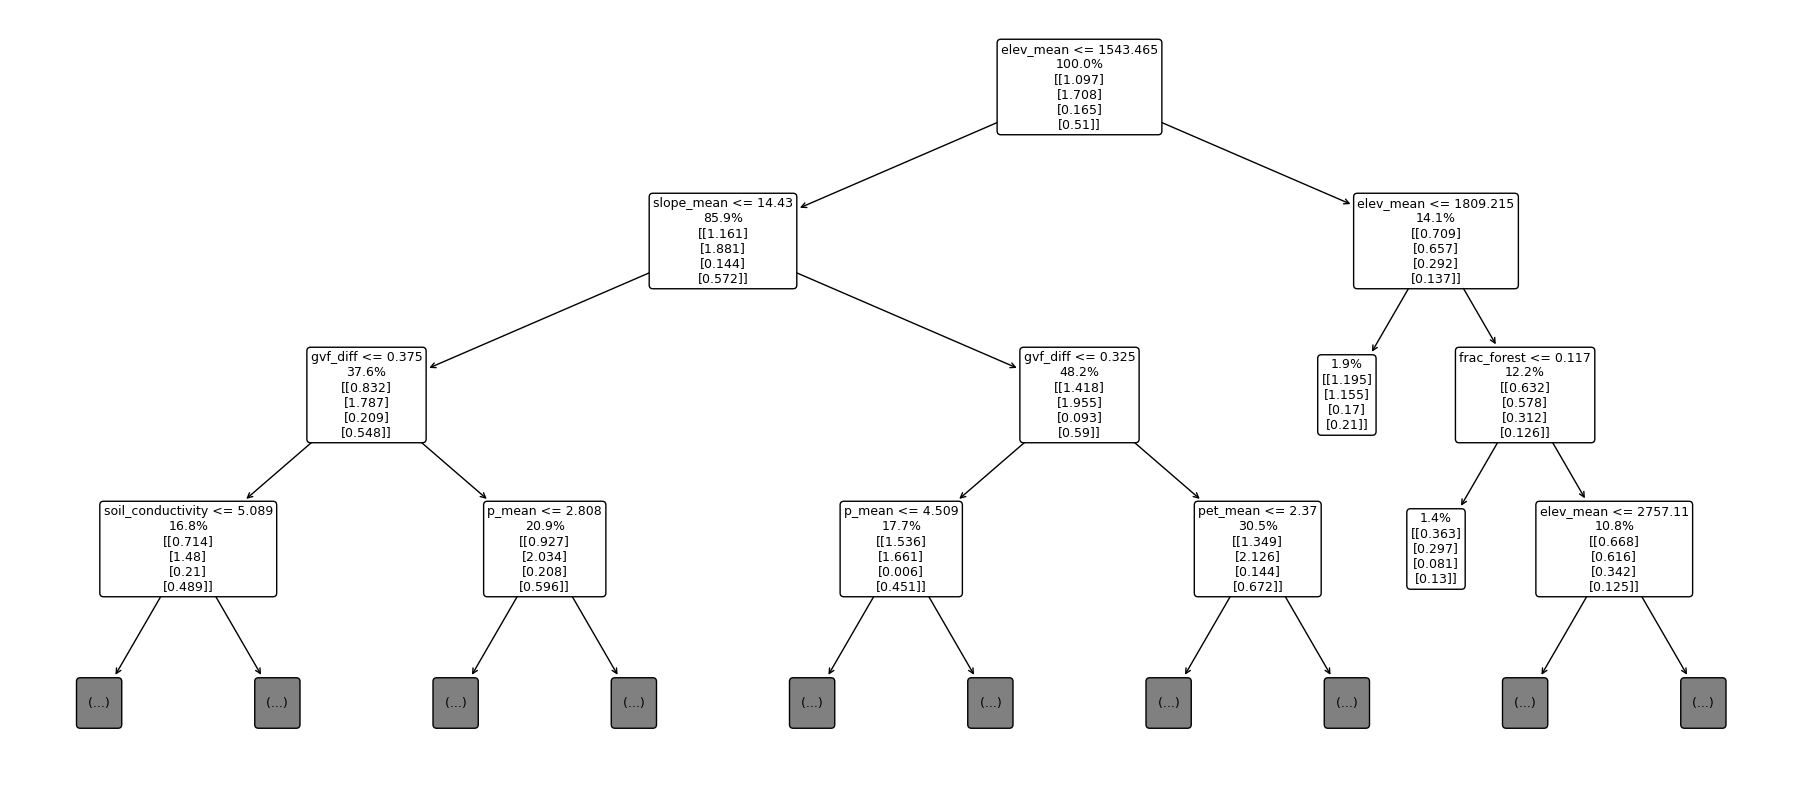

sh: dot: command not found
sh: dot: command not found


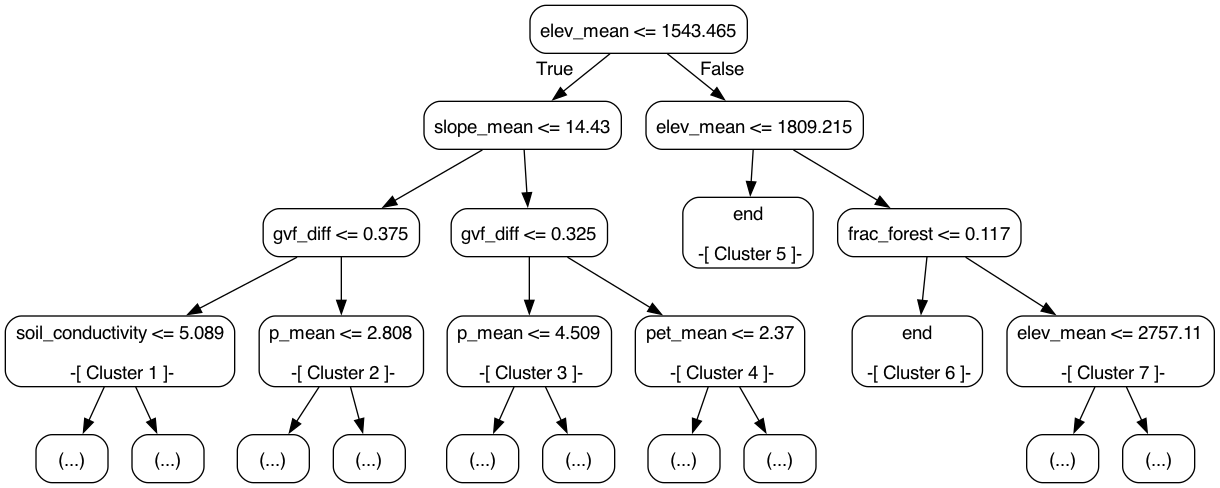

In [27]:
# Set the size of the plot figure
plt.figure(figsize=(23,10))

# Plot the decision tree
tree.plot_tree(simple_model,                   # The trained decision tree model
               max_depth=3,                    # Maximum depth to plot
               feature_names=code_att.columns, # Feature names
               label=None,                     # Don't label nodes
               impurity=False,                 # Don't show impurity at nodes
               proportion=True,                # Show proportion of samples at leaf nodes
               rounded=True,                   # Round the corners of nodes
               fontsize=9                      # Font size for text
              )

# Display the plot
plt.show()

# Export the decision tree to a DOT file
dotfile = open("dtree.dot", 'w')
tree.export_graphviz(simple_model,                               # The trained decision tree model
                     out_file=dotfile,                            # File to write the DOT data to
                     feature_names=list(code_att.columns.values), # Feature names
                     max_depth=3,                                 # Maximum depth to export
                     rounded=True                                 # Round the corners of nodes
                    )
dotfile.close()

# Convert the DOT file to a PNG image
os.system("dot -Tpng dtree.dot -o dtree.png")

# Export the decision tree to text representation
text_representation = tree.export_text(simple_model,             # The trained decision tree model
                                       feature_names=list(code_att.columns.values), # Feature names
                                       max_depth=3)               # Maximum depth to export

# Function to convert a DOT file to a text file
def dot_to_text(dot_file_path, text_file_path):
    with open(dot_file_path, "r") as dot_file:
        dot_content = dot_file.read()

    with open(text_file_path, "w") as text_file:
        text_file.write(dot_content)

# Function to change the file extension
def change_extension(input_file, new_extension):
    # Split the filename and extension
    file_name, _ = os.path.splitext(input_file)
    # Add the new extension
    output_file = file_name + '.' + new_extension
    # Rename the file
    os.rename(input_file, output_file)
    return output_file

# Function to simplify the tree representation
def simplify_tree(input_file, output_file, cluster_numbers):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    with open(output_file, 'w') as f:
        j = 1
        for line in lines:
            # Delete everything between '\' and ']'
            modified_line = re.sub(r'\\.*?"', '', line)
            # Replace "] ;" with ""];"
            modified_line = modified_line.replace("] ;", '"];')
            # Remove any extra double quotation marks
            modified_line = modified_line.replace('""', '"')

            modified_line = modified_line.replace("squared_error = 0.001", "end")
            modified_line = modified_line.replace("squared_error = 0.002", "end")
            modified_line = modified_line.replace("squared_error = 0.013", "end")
            modified_line = modified_line.replace("squared_error = 0.02", "end")

            if j in cluster_numbers:
                #print(i)
                modified_line = modified_line.replace('"];', cluster_numbers[j])

            f.write(modified_line)
            j = j+1

# Usage: Convert DOT file to text file
dot_to_text("dtree.dot", "dtree.txt")

# Define cluster numbers for simplifying the tree
cluster_numbers = {9: '\n \n -[ Cluster 1 ]-"];',
                   15: '\n \n -[ Cluster 2 ]-"];',
                   23: '\n \n -[ Cluster 3 ]-"];',
                   29: '\n \n -[ Cluster 4 ]-"];',
                   37: '\n \n -[ Cluster 5 ]-"];',
                   41: '\n \n -[ Cluster 6 ]-"];',
                   43: '\n \n -[ Cluster 7 ]-"];',
                   57: '\n \n -[ Cluster 8 ]-"];',
                   61: '\n \n -[ Cluster 9 ]-"];',
                   63: '\n \n -[ Cluster 10 ]-"];'
                  }

# Simplify the tree representation
simplify_tree('dtree.txt', 'dtree_mod.txt', cluster_numbers)

# Change the file extension from txt to DOT
change_extension("dtree_mod.txt", "dot")

# Convert the modified DOT file to a PNG image
os.system("dot -Tpng dtree_mod.dot -o dtree_mod.png")

# Path to the PNG file
png_file = "dtree_mod.png"

# Display the PNG image
Image(filename=png_file)



# Figure 8 Map of the Best desicion tree

In [28]:
# Get predicted values for all samples using the trained decision tree model
predicted_values = simple_model.predict(code_att)

# Initialize dictionary to store predicted values per level of the decision tree
predicted_values_per_level = {}

# Function to traverse the decision tree and collect predicted values per level
def traverse_tree(tree, node, level=0):
    if node == -1:  # Base case: leaf node
        return
    if level not in predicted_values_per_level:
        predicted_values_per_level[level] = []
    predicted_values_per_level[level].append(tree.value[node])  # Append predicted value at the current node to the list for the current level
    # Recursively traverse left and right children nodes
    traverse_tree(tree, tree.children_left[node], level + 1)
    traverse_tree(tree, tree.children_right[node], level + 1)

# Start traversal from the root node (index 0)
traverse_tree(simple_model.tree_, 0)

# Convert predicted values per level to numpy arrays for easier manipulation
predicted_values_per_level = {level: np.array(values) for level, values in predicted_values_per_level.items()}



In [29]:
# Define cluster names
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 6', 'Cluster 7']

# Define names for cluster values
clusters_values_names = ['Current PP', 'Previous PP', '10d PP', 'Previous PET']

# Create a DataFrame to store cluster values with rounded predictions from the decision tree
cluster_values = pd.DataFrame(np.round(predicted_values_per_level[3].squeeze(), 3), index=cluster_names, columns=clusters_values_names).T

# Reset index and rename the columns
cluster_values = cluster_values.reset_index()
cluster_values.rename(columns={'index': 'Weight'}, inplace=True)

# Add predictions for 'Cluster 5' to the DataFrame
cluster_values['Cluster 5'] = np.round(predicted_values_per_level[2].squeeze(), 3).T[:, 2]

# Reassign the 'Weight' column to match the column order
cluster_values['Weight'] = clusters_values_names

# Rearrange the columns to match the desired order
cluster_values = cluster_values[['Weight', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']]

# Display the DataFrame
cluster_values



Weight  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
0    Current PP      0.714      0.927      1.536      1.349      1.195   
1   Previous PP      1.480      2.034      1.661      2.126      1.155   
2        10d PP      0.210      0.208      0.006      0.144      0.170   
3  Previous PET      0.489      0.596      0.451      0.672      0.210   

   Cluster 6  Cluster 7  
0      0.363      0.668  
1      0.297      0.616  
2      0.081      0.342  
3      0.130      0.125

In [30]:
# Initialize a new column 'cluster' in the code_att DataFrame and set its initial value to -999
code_att['cluster'] = -999

# Create subsets of the DataFrame based on certain conditions
df1 = code_att.loc[(code_att.elev_mean <= 1543.465)].copy()
df2 = code_att.loc[(code_att.elev_mean > 1543.465)].copy()

df1_1 = df1.loc[df1.slope_mean <= 14.43].copy()
df1_2 = df1.loc[df1.slope_mean > 14.43].copy()

df2_1 = df2.loc[df2.elev_mean <= 1809.215].copy()
df2_2 = df2.loc[df2.elev_mean > 1809.215].copy()

df1_1_1 = df1_1.loc[df1_1.gvf_diff <= 0.375].copy()
df1_1_2 = df1_1.loc[df1_1.gvf_diff > 0.375].copy()

df1_2_1 = df1_2.loc[df1_2.gvf_diff <= 0.325].copy()
df1_2_2 = df1_2.loc[df1_2.gvf_diff > 0.325].copy()

df2_2_1 = df2_2.loc[df2_2.frac_forest <= 0.117].copy()
df2_2_2 = df2_2.loc[df2_2.frac_forest > 0.117].copy()

# Assign cluster numbers to corresponding rows in the 'cluster' column
code_att.loc[df1_1_1.index, 'cluster'] = 1
code_att.loc[df1_1_2.index, 'cluster'] = 2
code_att.loc[df1_2_1.index, 'cluster'] = 3
code_att.loc[df1_2_2.index, 'cluster'] = 4
code_att.loc[df2_1.index, 'cluster'] = 5
code_att.loc[df2_2_1.index, 'cluster'] = 6
code_att.loc[df2_2_2.index, 'cluster'] = 7

# Create lists of indices for each cluster
list_cluster1 = code_att[code_att.cluster == 1].index
list_cluster2 = code_att[code_att.cluster == 2].index
list_cluster3 = code_att[code_att.cluster == 3].index
list_cluster4 = code_att[code_att.cluster == 4].index
list_cluster5 = code_att[code_att.cluster == 5].index
list_cluster6 = code_att[code_att.cluster == 6].index
list_cluster7 = code_att[code_att.cluster == 7].index


In [31]:
# Construct the path to the attribute file
attr_path = path + '/' + 'gauge_information.csv'

# Read the attribute file into a DataFrame
attr = pd.read_csv(attr_path)

# Set the index of the attribute DataFrame to 'GAGE_ID'
attr.set_index('GAGE_ID', inplace=True)

# Construct the path to the list file
list_path = path + '/' + 'list_IDs_all.csv'

# Read the list file into a DataFrame
geo_list = pd.read_csv(list_path)

# Set the index of the 'geo_list' DataFrame to the values of 'GAGE_ID'
geo_list.index = geo_list['GAGE_ID'].values

# Add columns for latitude, longitude, and area from the attribute DataFrame to the 'geo_list' DataFrame
geo_list['Lat'] = attr.LAT
geo_list['Long'] = attr.LONG
geo_list['Area'] = attr.area

# Filter 'geo_list' based on condition RF_mean.KGE_testing > KGE_lim
geo_list = geo_list.loc[RF_mean.KGE_testing > KGE_lim]

# Add latitude and longitude columns from 'geo_list' to the 'RF_mean' DataFrame
RF_mean['Lat'] = geo_list.Lat
RF_mean['Long'] = geo_list.Long


In [32]:
# Read the CSV file 'list.csv' into a DataFrame
code_list = pd.read_csv('list.csv')

# Read the CSV file 'gauge_information.csv' into a DataFrame, setting 'GAGE_ID' as the index
code_att_original = pd.read_csv('gauge_information.csv', index_col='GAGE_ID')

# Filter the rows of 'code_att_original' based on the index of 'RF_mean_weight'
code_att_original = code_att_original.loc[RF_mean_weight.index]

# Add 'LAT' and 'LONG' columns from 'code_att_original' to the 'code_att' DataFrame
code_att['LAT'] = code_att_original.LAT
code_att['LONG'] = code_att_original.LONG


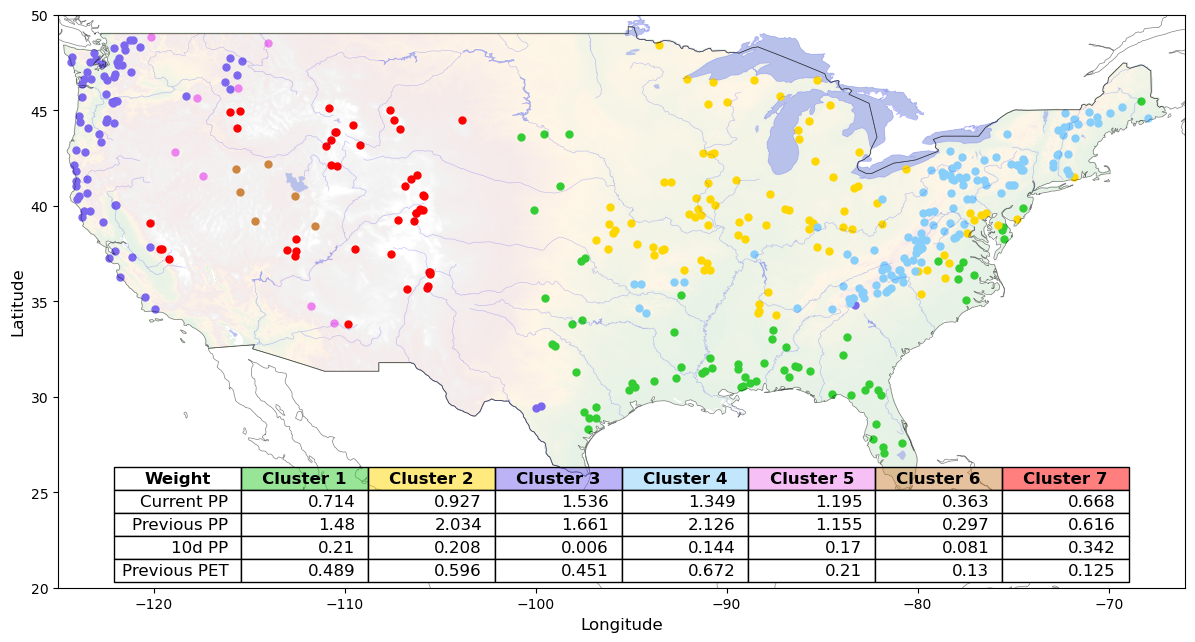

In [33]:
# Read shapefiles into GeoDataFrames
df_continent = geopandas.read_file(current_dir + '/shp/Americas.shp')
df_drainage_network = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Hidrografia.shp')
df_lakes = geopandas.read_file(current_dir + '/shp/Estados_Unidos_Lagos.shp')

# Read raster data
fp = current_dir + '/elevation.tif'
img = rasterio.open(fp, 'r')

# Define color and value ranges for elevation visualization
cvals = [-11, 0, 500, 1000, 2000, 3000]
colors = ["white", "green", "orange", "brown", "gray", "white"]
norm_blue = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm_blue, cvals), colors))
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

# Create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 16))
fig.tight_layout()

# Plot continent boundary, drainage network, and lakes
df_continent.boundary.plot(color='black', ax=ax, lw=0.5, alpha=0.5)
df_drainage_network.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
df_lakes.plot(color='blue', ax=ax, lw=0.5, alpha=0.2)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlim([-125, -66])
ax.set_ylim([20, 50])

# Define markers and colors for clusters
markers_cluster = {0: 'o', 1: 'o', 2: 'o', 3: 'o', 4: 'o', 5: 'o', 6: 'o', 7: 'o', 8: 'o', 9: 'o'}
colors_clusters = {1: 'limegreen', 2: 'gold', 3: 'mediumslateblue', 4: 'lightskyblue', 5: 'violet', 6: 'peru', 7: 'red', 8: 'orange', 0: 'white'}

# Scatter plot for clusters
scatter_handles = []
for i in range(1, 8):
    scatter = ax.scatter(code_att.LONG[code_att.cluster == i],
                         code_att.LAT[code_att.cluster == i],
                         marker='o',
                         s=25,
                         color=colors_clusters[i],
                         label='cluster: ' + str(i))
    scatter_handles.append((scatter,))

# Show raster image
show((img, 1), ax=ax, cmap=cmap_blue, norm=norm_blue, alpha=0.1)

# Add the DataFrame as a table
table = ax.table(cellText=cluster_values.values, colLabels=cluster_values.columns,
                 bbox=[0.05, 0.01, 0.9, 0.2], alpha=1, cellColours=[['white'] * len(cluster_values.columns)] * len(cluster_values))

# Adjust the table layout
table.auto_set_font_size(False)
table.set_fontsize(12)
table.set_alpha(0.5)

# Formatting the header row
j = 0
for (i, cell) in table.get_celld().items():
    if i[0] == 0:  # Header row
        cell.set_text_props(fontweight='bold')
        color_with_alpha = mcolors.to_rgba(colors_clusters[j], alpha=0.5)
        cell.set_facecolor(color_with_alpha)
        j = j + 1
    else:
        cell.set_facecolor('white')

# Adjust the z-order to make sure the table is drawn on top
table.set_zorder(10)

# Save the plot
plt.savefig('Fig 8 Map with clusters.jpg', bbox_inches="tight")


# Figure 9 Time series example

In [34]:
# Open the netCDF file containing forcing data
forcing = xr.open_dataset("forcing_mauren.nc")

# Define paths for regional model outputs
path_best_regional_model = parent_dir + '/Results' + '/RF_mean/'
Q_path = path_best_regional_model + '1000000_C1_L512_regionalhydro_predictions_testing.csv'

# Read streamflow data
streamflow = pd.read_csv(Q_path)
streamflow = streamflow.drop(['Unnamed: 0'], axis=1)  # Drop unnecessary column
streamflow = streamflow.iloc[2:, :]  # Remove first two rows
streamflow = streamflow.rename(columns={'0': 'obs', '1': 'sim', '2': 'ID', '3': 'date'})  # Rename columns
streamflow = streamflow.set_index(['ID', 'date'])  # Set multi-index
streamflow = xr.Dataset.from_dataframe(streamflow)  # Convert to xarray Dataset
streamflow['ID'] = streamflow.ID.astype(int)  # Convert ID to integer
streamflow['date'] = pd.to_datetime(streamflow.date)  # Convert date to datetime

# Read state data
states_path = path_best_regional_model + '1000000_C1_L512_regionalhydro_state_testing.csv'
state = pd.read_csv(states_path, names=['a', 'state', 'ID', 'date'], index_col=['ID', 'date'], low_memory=False)
state = state.iloc[3:, :]  # Remove first three rows
state.drop(columns='a', inplace=True)  # Drop unnecessary column
state = xr.Dataset.from_dataframe(state)  # Convert to xarray Dataset
state['date'] = pd.to_datetime(state['date'])  # Convert date to datetime
state['ID'] = state.ID.astype(int)  # Convert ID to integer

# Read regression weights data
regression_path = path_best_regional_model + '1000000_C1_L512_regionalhydro_regression_testing.csv'
regression_weights = pd.read_csv(regression_path, index_col='GAGE_ID')


In [35]:
# Define RGB values for red color for colorblindness and normalize them
red_colorblindness = (216, 27, 96)  # RGB values for red
red_colorblindness = tuple(c/255.0 for c in red_colorblindness)  # Normalize to range [0, 1]

# Define RGB values for blue color for colorblindness and normalize them
blue_colorblindness = (30, 136, 229)  # RGB values for blue
blue_colorblindness = tuple(c/255.0 for c in blue_colorblindness)  # Normalize to range [0, 1]

# Define RGB values for yellow color for colorblindness and normalize them
yellow_colorblindness = (255, 193, 7)  # RGB values for yellow
yellow_colorblindness = tuple(c/255.0 for c in yellow_colorblindness)  # Normalize to range [0, 1]

# Define RGB values for green color for colorblindness and normalize them
green_colorblindness = (0, 77, 64)  # RGB values for green
green_colorblindness = tuple(c/255.0 for c in green_colorblindness)  # Normalize to range [0, 1]


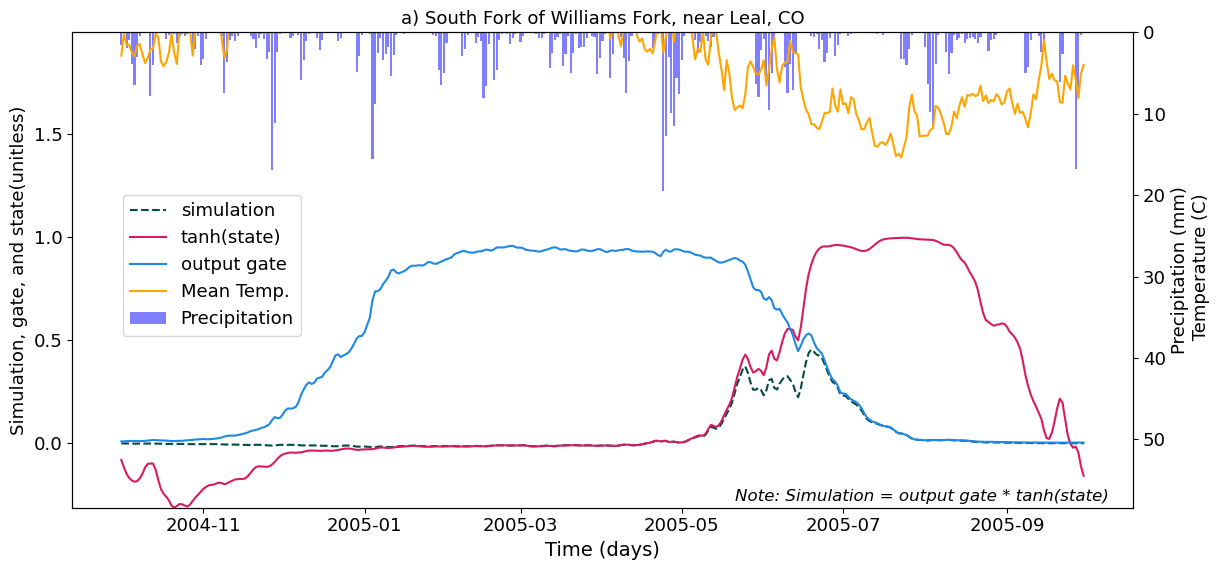

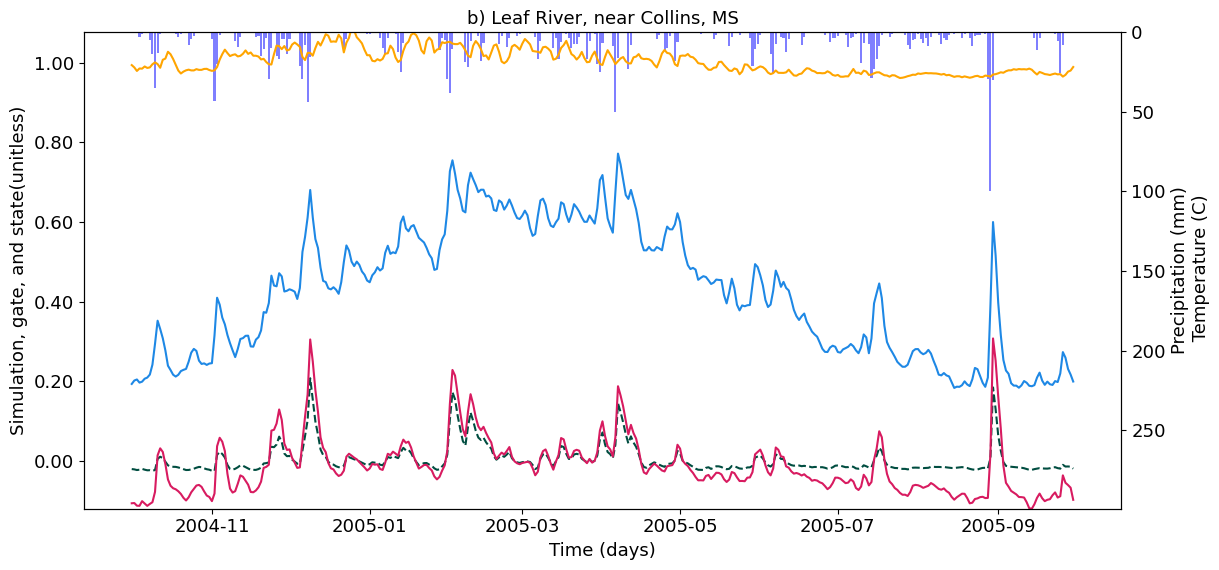

In [36]:
# Define the catchment ID, initial and end dates
ID_catchment = 9035900
initial = '2004-10-01'
end = '2005-09-30'

# Extract precipitation data for the specified period and catchment ID
PP = forcing.sel(date=slice(initial, end),ID=ID_catchment).prcp

# Scale the observed streamflow data using min-max normalization
scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()
obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
obs = (obs - scaler_mean)/(scaler_max-scaler_min)
obs = (obs - regression_weights.loc[ID_catchment][1])/ regression_weights.loc[ID_catchment][0]

# Scale the simulated streamflow data using min-max normalization
sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
sim = (sim - scaler_mean)/(scaler_max-scaler_min)
sim = (sim - regression_weights.loc[ID_catchment][1])/ regression_weights.loc[ID_catchment][0]

# Extract state variable data for the specified period and catchment ID
state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
state_var = np.tanh(state_var)

# Extract temperature data and calculate mean temperature for the specified period and catchment ID
date = forcing.sel(date=slice(initial, end),ID=ID_catchment).date
temp = (forcing.sel(date=slice(initial, end),ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end),ID=ID_catchment).tmin)/2

# Plotting
fig_a,ax_a = plt.subplots(figsize=(12,5.5))  # Create a figure and axis
days = np.arange(len(obs))  # Create an array of days
#ax_a.plot(date, obs,color='gray',linestyle='--', label='Observations',alpha=1)  # Plot observed streamflow
ax_a.plot(date, sim,color=green_colorblindness, linestyle='--', label='simulation', alpha=1)  # Plot simulated streamflow
ax_a.plot(date, state_var,color=red_colorblindness, label='tanh(state)', alpha=1)  # Plot state variable
ax_a.plot(date, sim/state_var, color=blue_colorblindness, label='output gate', alpha=1)  # Plot output gate

ax_a.text(ax_a.get_xlim()[1] - 150 , ax_a.get_ylim()[0] + 0.1, 'Note: Simulation = output gate * tanh(state)', fontsize=12, fontstyle='italic')

# Set y-axis limit for the axis
ax_a.set_ylim(min(state_var.min(),sim.min()),2*state_var.max())
#ax_a.set_ylabel('Simulation, Observation, and state(unitless)', fontsize=13)  # Set y-axis label
ax_a.set_ylabel('Simulation, gate, and state(unitless)', fontsize=13)  # Set y-axis label
ax_a.set_xlabel('Time (days)', fontsize=14)  # Set x-axis label
ax_a.set_title('a) South Fork of Williams Fork, near Leal, CO', fontsize=13)  # Set plot title
ax_a.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
ax_a.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

# Create a twin axis for precipitation and temperature
ax2 = ax_a.twinx()
ax2.invert_yaxis()  # Invert y-axis for precipitation
ax2.bar(date, PP, color='blue', label='Precipitation', alpha=0.5)  # Plot precipitation
ax2.plot(date, temp, color='orange', label='Mean Temp.', alpha=1)  # Plot mean temperature
ax2.set_ylim(3*PP.max(),0)  # Set y-axis limit for the twin axis
ax2.set_ylabel('Precipitation (mm)\n Temperature (C)', fontsize=13)  # Set y-axis label for the twin axis
ax2.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size for the twin axis

# Add legend to the plot
fig_a.legend(bbox_to_anchor=(0.25,0.68), fontsize=13)  # Specify legend position and font size
plt.tight_layout(pad=0)  # Adjust layout

# Save the plot
plt.savefig('Fig 9 hydrograph_a.jpg',bbox_inches='tight')  # Save the plot as an image file


# -------------------------------------------------------------------------------------------------------------------------------------
# Define the catchment ID, initial and end dates
ID_catchment = 2472000

# Extract precipitation data for the specified period and catchment ID
PP = forcing.sel(date=slice(initial, end),ID=ID_catchment).prcp

# Scale the observed streamflow data using min-max normalization
scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()
obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
obs = (obs - scaler_mean)/(scaler_max-scaler_min)
obs = (obs - regression_weights.loc[ID_catchment][1])/ regression_weights.loc[ID_catchment][0]

# Scale the simulated streamflow data using min-max normalization
sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
sim = (sim - scaler_mean)/(scaler_max-scaler_min)
sim = (sim - regression_weights.loc[ID_catchment][1])/ regression_weights.loc[ID_catchment][0]

# Extract state variable data for the specified period and catchment ID
state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
state_var = np.tanh(state_var)

# Extract temperature data and calculate mean temperature for the specified period and catchment ID
date = forcing.sel(date=slice(initial, end),ID=ID_catchment).date
temp = (forcing.sel(date=slice(initial, end),ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end),ID=ID_catchment).tmin)/2

# Plotting
fig_b,ax_b = plt.subplots(figsize=(12,5.5))  # Create a figure and axis
days = np.arange(len(obs))  # Create an array of days
#ax_b.plot(date, obs,color='gray',linestyle='--', label='Observations',alpha=1)  # Plot observed streamflow
ax_b.plot(date, sim,color=green_colorblindness, linestyle='--', label='simulation', alpha=1)  # Plot simulated streamflow
ax_b.plot(date, state_var,color=red_colorblindness, label='tanh(state)', alpha=1)  # Plot state variable
ax_b.plot(date, sim/state_var, color=blue_colorblindness, label='output gate', alpha=1)  # Plot output gate

# Set y-axis limit for the axis
ax_b.set_ylim(min(state_var.min(),sim.min()),3.5*state_var.max())
#ax_b.set_ylabel('Simulation, Observation, and state(unitless)', fontsize=13)  # Set y-axis label
ax_b.set_ylabel('Simulation, gate, and state(unitless)', fontsize=13)  # Set y-axis label
ax_b.set_xlabel('Time (days)', fontsize=13)  # Set x-axis label
ax_b.set_title('b) Leaf River, near Collins, MS', fontsize=13)  # Set plot title
ax_b.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
ax_b.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

# Set y-axis to display three decimal places
ax_b.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Create a twin axis for precipitation and temperature
ax2 = ax_b.twinx()
ax2.invert_yaxis()  # Invert y-axis for precipitation
ax2.bar(date, PP, color='blue', label='Precipitation', alpha=0.5)  # Plot precipitation
ax2.plot(date, temp, color='orange', label='Max. Temperature ', alpha=1)  # Plot mean temperature
ax2.set_ylim(3*PP.max(),0)  # Set y-axis limit for the twin axis
ax2.set_ylabel('Precipitation (mm)\n Temperature (C)', fontsize=13)  # Set y-axis label for the twin axis
ax2.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size for the twin axis

# Adjust layout
plt.tight_layout(pad=0)

# Save the plot
plt.savefig('Fig 9 hydrograph_b.jpg',bbox_inches='tight')  # Save the plot as an image file


# # -------------------------------------------------------------------------------------------------------------------------------------

from PIL import Image  # Import the Image module from the Python Imaging Library (PIL)

# Open the images
image1 = Image.open("Fig 9 hydrograph_a.jpg")  # Open the first image
image2 = Image.open("Fig 9 hydrograph_b.jpg")  # Open the second image

# Calculate the height of the gap (10 pixels)
gap_height = 10

# Create a white image with the gap dimensions
gap_image = Image.new("RGB", (image1.width, gap_height), color="white")

# Create a new image with the required dimensions
merged_image = Image.new("RGB", (image1.width, image1.height + gap_height + image2.height))

# Paste the first image onto the new image
merged_image.paste(image1, (0, 0))

# Paste the white gap image below the first image
merged_image.paste(gap_image, (0, image1.height))

# Paste the second image below the gap image
merged_image.paste(image2, (0, image1.height + gap_height))

# Save the merged image
merged_image.save("Fig 9 state hydrograph.jpg")  # Save the merged image as an image file

# deleting temporal images
os.remove('Fig 9 hydrograph_a.jpg')
os.remove('Fig 9 hydrograph_b.jpg')

# Figure S4 Time series example in Recent rainfall-dominated catchments

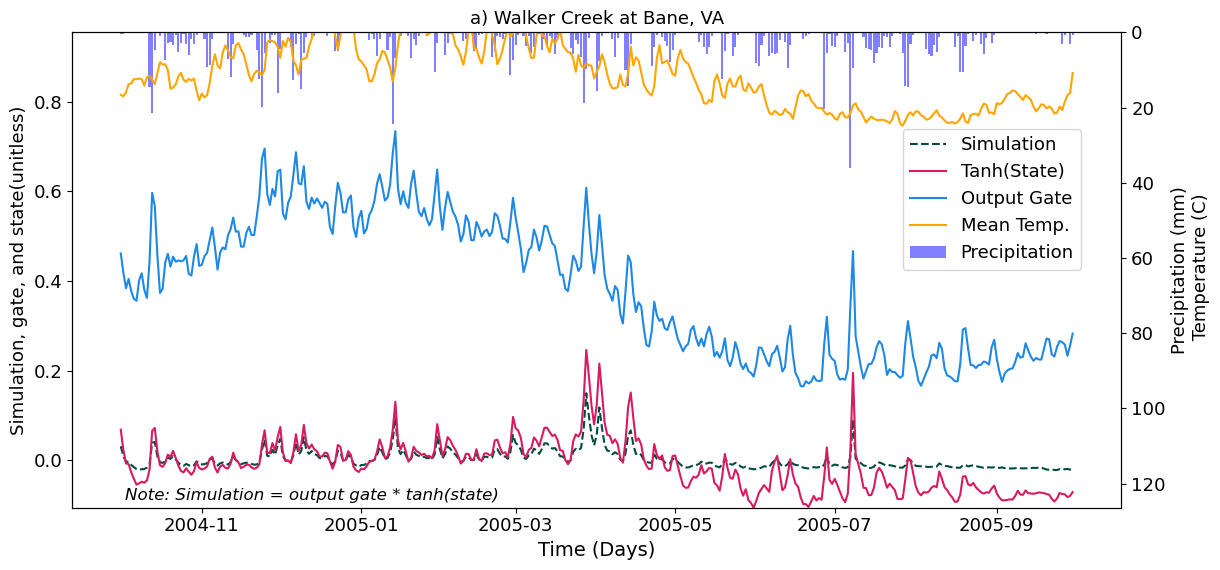

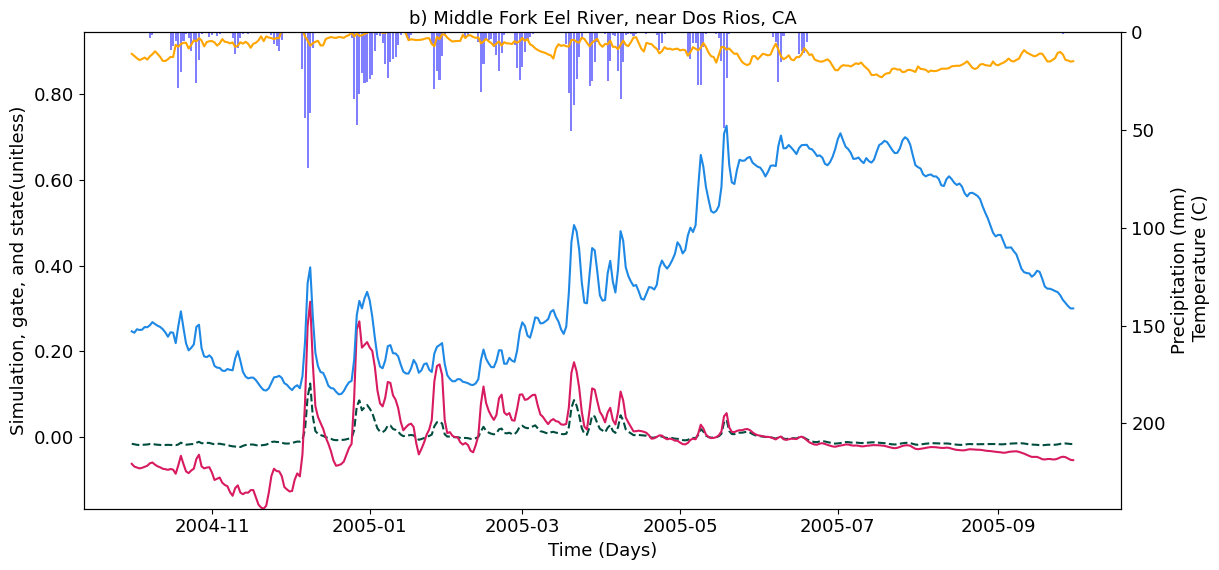

In [37]:
ID_catchment = 3173000  # Set the catchment ID
initial = '2004-10-01'  # Define the start date
end = '2005-09-30'  # Define the end date

# Select precipitation data for the specified catchment and time period
PP = forcing.sel(date=slice(initial, end), ID=ID_catchment).prcp

# Calculate scaling factors for observed streamflow data
scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()

# Normalize and scale observed streamflow data
obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
obs = (obs - scaler_mean) / (scaler_max - scaler_min)
obs = (obs - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

# Normalize and scale simulated streamflow data
sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
sim = (sim - scaler_mean) / (scaler_max - scaler_min)
sim = (sim - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

# Retrieve state variable data for the specified catchment and time period
state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
state_var = np.tanh(state_var)  # Apply hyperbolic tangent function for normalization

# Retrieve date and temperature data for the specified catchment and time period
date = forcing.sel(date=slice(initial, end), ID=ID_catchment).date
temp = (forcing.sel(date=slice(initial, end), ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end), ID=ID_catchment).tmin) / 2

# Create a new figure and axis for plotting
fig_a, ax_a = plt.subplots(figsize=(12, 5.5))

# Plot observation, simulation, state variable, and output gate data
#ax_a.plot(date, obs, color='gray', linestyle='--', label='Observations', alpha=1)
ax_a.plot(date, sim, color=green_colorblindness, label='Simulation', linestyle='--',alpha=1)
ax_a.plot(date, state_var, color=red_colorblindness, label='Tanh(State)', alpha=1)
ax_a.plot(date, sim/state_var, color=blue_colorblindness, label='Output Gate', alpha=1)


ax_a.text(ax_a.get_xlim()[0] + 20 , ax_a.get_ylim()[0] + 0.06, 'Note: Simulation = output gate * tanh(state)', fontsize=12, fontstyle='italic')

# Set y-axis limits
ax_a.set_ylim(min(state_var.min(), sim.min()), 2 * state_var.max())

# Set labels and title
ax_a.set_ylabel('Simulation, gate, and state(unitless)', fontsize=13)  # Set y-axis label
ax_a.set_xlabel('Time (Days)', fontsize=14)
ax_a.set_title('a) Walker Creek at Bane, VA', fontsize=13)

# Set tick parameters
ax_a.tick_params(axis='x', labelsize=13)
ax_a.tick_params(axis='y', labelsize=13)

# Set y-axis limits
ax_a.set_ylim(state_var.min(), 1.3 * max(sim/state_var))

# Create a second y-axis for precipitation and temperature
ax2 = ax_a.twinx()
ax2.invert_yaxis()

# Plot precipitation and temperature data
ax2.bar(date, PP, color='blue', label='Precipitation', alpha=0.5)
ax2.plot(date, temp, color='orange', label='Mean Temp.', alpha=1)

# Set y-axis limits for precipitation and temperature
ax2.set_ylim(3.5 * PP.max(), 0)

# Set y-axis label for precipitation and temperature
ax2.set_ylabel('Precipitation (mm)\n Temperature (C)', fontsize=13)

# Set tick parameters for the second y-axis
ax2.tick_params(axis='y', labelsize=13)

# Add legend
fig_a.legend(bbox_to_anchor=(0.9, 0.8), fontsize=13)

# Adjust layout and save the figure
plt.tight_layout(pad=0)
plt.savefig('Fig S4 hydrograph_a.jpg')


# -------------------------------------------------------------------------------------------------------------------------------------
ID_catchment = 11473900  # Define the catchment ID
initial = '2004-10-01'  # Define the start date
end = '2005-09-30'  # Define the end date

# Select precipitation data for the specified catchment and time period
PP = forcing.sel(date=slice(initial, end), ID=ID_catchment).prcp

# Calculate scaling factors for observed streamflow data
scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()

# Normalize and scale observed streamflow data
obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
obs = (obs - scaler_mean) / (scaler_max - scaler_min)
obs = (obs - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

# Normalize and scale simulated streamflow data
sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
sim = (sim - scaler_mean) / (scaler_max - scaler_min)
sim = (sim - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

# Retrieve state variable data for the specified catchment and time period
state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
state_var = np.tanh(state_var)  # Apply hyperbolic tangent function for normalization

# Retrieve date and temperature data for the specified catchment and time period
date = forcing.sel(date=slice(initial, end), ID=ID_catchment).date
temp = (forcing.sel(date=slice(initial, end), ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end), ID=ID_catchment).tmin) / 2

# Create a new figure and axis for plotting
fig_b, ax_b = plt.subplots(figsize=(12, 5.5))

# Plot observation, simulation, state variable, and output gate data
#ax_b.plot(date, obs, color='gray', linestyle='--', label='Observations', alpha=1)
ax_b.plot(date, sim, color=green_colorblindness, label='Simulation', linestyle='--',alpha=1)
ax_b.plot(date, state_var, color=red_colorblindness, label='Tanh(State)', alpha=1)
ax_b.plot(date, sim/state_var, color=blue_colorblindness, label='Output Gate', alpha=1)

# Set y-axis limits
ax_b.set_ylim(min(state_var.min(), sim.min()), 3.5 * state_var.max())

# Set labels and title
ax_b.set_ylabel('Simulation, gate, and state(unitless)', fontsize=13)  # Set y-axis label
ax_b.set_xlabel('Time (Days)', fontsize=13)
ax_b.set_title('b) Middle Fork Eel River, near Dos Rios, CA', fontsize=13)

# Set tick parameters
ax_b.tick_params(axis='x', labelsize=13)
ax_b.tick_params(axis='y', labelsize=13)

# Set y-axis limits
ax_b.set_ylim(state_var.min(), 1.3 * max(sim/state_var))

# Set y-axis to display three decimal places
ax_b.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Create a second y-axis for precipitation and temperature
ax2 = ax_b.twinx()
ax2.invert_yaxis()

# Plot precipitation and temperature data
ax2.bar(date, PP, color='blue', label='Precipitation', alpha=0.5)
ax2.plot(date, temp, color='orange', label='Max. Temperature ', alpha=1)

# Set y-axis limits for precipitation and temperature
ax2.set_ylim(3.5 * PP.max(), 0)

# Set y-axis label for precipitation and temperature
ax2.set_ylabel('Precipitation (mm)\n Temperature (C)', fontsize=13)

# Set tick parameters for the second y-axis
ax2.tick_params(axis='y', labelsize=13)

# Adjust layout and save the figure
plt.tight_layout(pad=0)
plt.savefig('Fig S4 hydrograph_b.jpg')


# # -------------------------------------------------------------------------------------------------------------------------------------

# Open the images
image1 = Image.open("Fig S4 hydrograph_a.jpg")
image2 = Image.open("Fig S4 hydrograph_b.jpg")

# Calculate the height of the gap (10 pixels)
gap_height = 10

# Create a white image with the gap dimensions
gap_image = Image.new("RGB", (image1.width, gap_height), color="white")

# Create a new image with the required dimensions
merged_image = Image.new("RGB", (image1.width, image1.height + gap_height + image2.height))

# Paste the first image onto the new image
merged_image.paste(image1, (0, 0))

# Paste the white gap image below the first image
merged_image.paste(gap_image, (0, image1.height))

# Paste the second image below the gap image
merged_image.paste(image2, (0, image1.height + gap_height))

merged_image.save("Fig S4 state hydrograph.jpg")

# deleting temporal images
os.remove("Fig S4 hydrograph_a.jpg")
os.remove("Fig S4 hydrograph_b.jpg")

## S5 Time series variability per cluster

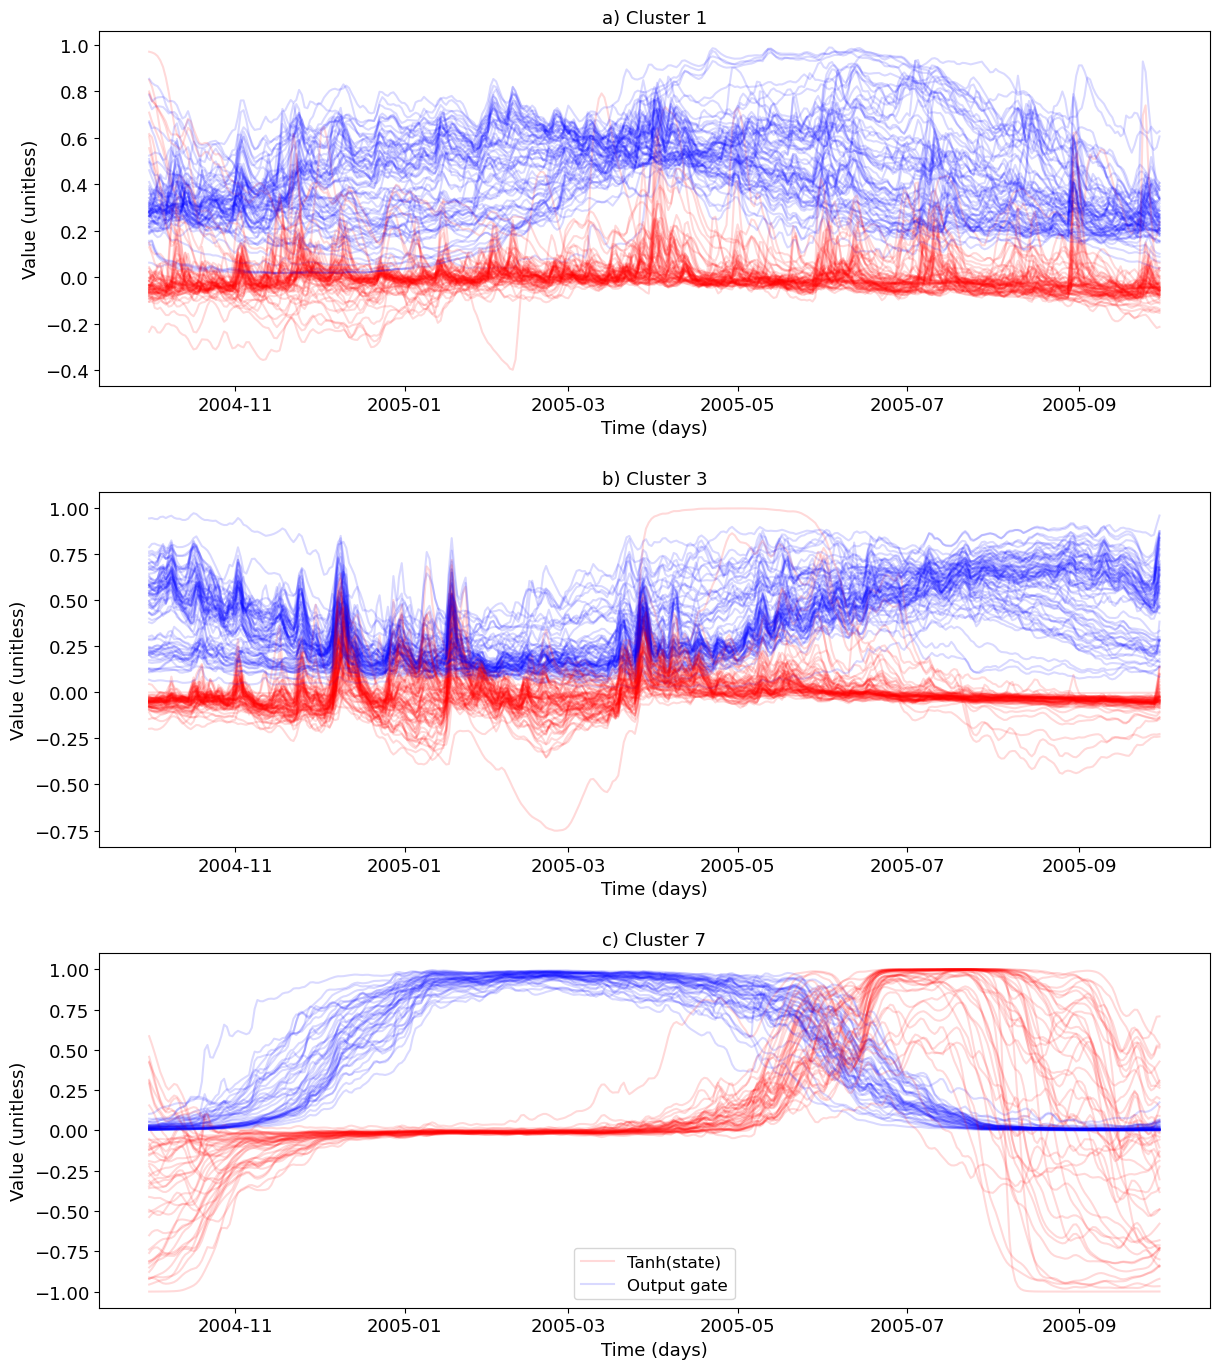

In [38]:
# Define the time period of interest
initial = '2004-10-01'
end = '2005-09-30'

# Create a subplot with 3 rows and 1 column, and set the figure size
fig, ax = plt.subplots(3, 1, figsize=(12, 13.5))

# Iterate over catchments in cluster 1
for ID_catchment in list_cluster1:
    # Calculate scaling factors for observed streamflow data
    scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
    scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
    scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()
    
    # Normalize and scale observed streamflow data
    obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
    obs = (obs - scaler_mean) / (scaler_max - scaler_min)
    obs = (obs - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]
    
    # Normalize and scale simulated streamflow data
    sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
    sim = (sim - scaler_mean) / (scaler_max - scaler_min)
    sim = (sim - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

    # Retrieve state variable data for the specified catchment and time period
    state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
    state_var = np.tanh(state_var)  # Apply hyperbolic tangent function for normalization
    
    # Retrieve date and temperature data for the specified catchment and time period
    date = forcing.sel(date=slice(initial, end), ID=ID_catchment).date
    temp = (forcing.sel(date=slice(initial, end), ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end), ID=ID_catchment).tmin) / 2

    # Plot state variable and output gate data for the current catchment
    ax[0].plot(date, state_var, '-r', label='tanh(state)', alpha=0.15)
    ax[0].plot(date, sim/state_var, '-b', label='output gate', alpha=0.15)

# Set y-axis label and title for the subplot
ax[0].set_ylabel('Value (unitless)', fontsize=13)
ax[0].set_xlabel('Time (days)', fontsize=13)
ax[0].set_title('a) Cluster 1', fontsize=13)

# Set tick parameters for the x and y axes
ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)


# Iterate over catchments in cluster 3
for ID_catchment in list_cluster3:
    # Calculate scaling factors for observed streamflow data
    scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
    scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
    scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()
    
    # Normalize and scale observed streamflow data
    obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
    obs = (obs - scaler_mean) / (scaler_max - scaler_min)
    obs = (obs - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]
    
    # Normalize and scale simulated streamflow data
    sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
    sim = (sim - scaler_mean) / (scaler_max - scaler_min)
    sim = (sim - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

    # Retrieve state variable data for the specified catchment and time period
    state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
    state_var = np.tanh(state_var)  # Apply hyperbolic tangent function for normalization
    
    # Retrieve date and temperature data for the specified catchment and time period
    date = forcing.sel(date=slice(initial, end), ID=ID_catchment).date
    temp = (forcing.sel(date=slice(initial, end), ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end), ID=ID_catchment).tmin) / 2

    # Plot state variable and output gate data for the current catchment
    ax[1].plot(date, state_var, '-r', label='tanh(state)', alpha=0.15)
    ax[1].plot(date, sim/state_var, '-b', label='output gate', alpha=0.15)

# Set y-axis label and title for the subplot
ax[1].set_ylabel('Value (unitless)', fontsize=13)
ax[1].set_xlabel('Time (days)', fontsize=13)
ax[1].set_title('b) Cluster 3', fontsize=13)

# Set tick parameters for the x and y axes
ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)

# Iterate over catchments in cluster 7
for ID_catchment in list_cluster7:
    # Calculate scaling factors for observed streamflow data
    scaler_max = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).max()
    scaler_mean = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).mean()
    scaler_min = streamflow.sel(date=slice('1981-10-29', '2000-09-30'), ID=ID_catchment).obs.astype(float).min()
    
    # Normalize and scale observed streamflow data
    obs = streamflow.sel(date=slice(initial, end), ID=ID_catchment).obs.astype(float)
    obs = (obs - scaler_mean) / (scaler_max - scaler_min)
    obs = (obs - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]
    
    # Normalize and scale simulated streamflow data
    sim = streamflow.sel(date=slice(initial, end), ID=ID_catchment).sim
    sim = (sim - scaler_mean) / (scaler_max - scaler_min)
    sim = (sim - regression_weights.loc[ID_catchment][1]) / regression_weights.loc[ID_catchment][0]

    # Retrieve state variable data for the specified catchment and time period
    state_var = state.sel(date=slice(initial, end), ID=ID_catchment).state
    state_var = np.tanh(state_var)  # Apply hyperbolic tangent function for normalization
    
    # Retrieve date and temperature data for the specified catchment and time period
    date = forcing.sel(date=slice(initial, end), ID=ID_catchment).date
    temp = (forcing.sel(date=slice(initial, end), ID=ID_catchment).tmax + forcing.sel(date=slice(initial, end), ID=ID_catchment).tmin) / 2

    # Plot state variable and output gate data for the current catchment
    ax[2].plot(date, state_var, '-r', label='tanh(state)', alpha=0.15)
    ax[2].plot(date, sim/state_var, '-b', label='output gate', alpha=0.15)

# Set y-axis label and title for the subplot
ax[2].set_ylabel('Value (unitless)', fontsize=13)
ax[2].set_xlabel('Time (days)', fontsize=13)
ax[2].set_title('c) Cluster 7', fontsize=13)

# Set tick parameters for the x and y axes
ax[2].tick_params(axis='x', labelsize=13)
ax[2].tick_params(axis='y', labelsize=13)

# Add legend to the subplot
ax[2].legend(['Tanh(state)', 'Output gate'], fontsize=12)

# Adjust layout and spacing
plt.tight_layout(pad=0)
plt.subplots_adjust(hspace=0.3)

# Save the plot as an image file
plt.savefig('Fig A1 State and output gate evolution per cluster.jpg')
